In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
FORCE = True

> "Let us change our traditional attitude to the construction of programs: Instead of imagining that our main task is to instruct a computer what to do, let us concentrate rather on explaining to human beings what we want a computer to do." (Donald Knuth. "Literate Programming (1984)" in Literate Programming. CSLI, 1992, pg. 99).

# Text Quality Analysis (TQA) 
Review text quality is an indicator of the content's richness, coherence, and informativeness. In this section, we integrate two complementary quality assessment measures—a lexical/syntactic complexity score and a perplexity-based coherence score—into a weighted sum. This approach provides a balanced evaluation, capturing both the structural diversity and natural language fluency of the reviews.

## Syntactic and Lexical Complexity Assessment
The lexical and syntactic quality assessment (TQA) evaluates review quality using a composite score derived from multiple syntactic and lexical measures. These measures are computed with specific weights:

- **Syntactic Diversity Score** (30%): Captures variety in language using an entropy-based calculation.
- **Syntactic Density Score** (30%): Assesses the density of key parts of speech relative to total word count.
- **Lexical Complexity Score** (40%): Evaluates text complexity using unique word proportion, special character usage, and word length variation.


A high Lexical and Syntactic Complexity Score typically indicates a text rich in linguistic features, with varied sentence structures and a well-balanced mix of nouns, verbs, and modifiers (like adjectives and adverbs). This variety is particularly valuable for tasks like Aspect-Based Sentiment Analysis (ABSA), where structural complexity can signal content with nuanced aspects and sentiments.

## Perplexity-Based Coherence Scoring
This measure evaluates review quality by applying 14 linguistic and structural filters, each assigned a weight derived from relative perplexity differences between the full dataset and filtered subsets. The filters assess features like adjective presence, punctuation ratios, word repetition, and special character use. Weights are computed to emphasize filters that most reduce perplexity, thus enhancing text fluency and coherence. The final score is a weighted sum of these filter indicators.

Lower perplexity implies higher fluency, coherence, and grammatical correctness, which are key indicators of text quality. This component is useful for flagging low-quality or noisy text that may be unpredictable or deviate significantly from standard linguistic norms.

## Weighted Scoring Approach
To create a balanced quality score, the Syntactic Complexity Score and Perplexity-Based Score are combined with tailored weights that emphasize their respective strengths.

- **Lexical and Syntactic Complexity Weight**: Typically given more weight when the task demands detailed and linguistically rich text, such as ABSA, where richer syntactic content improves aspect and sentiment extraction.
- **Perplexity-Based Weight**: Often assigned a moderate weight to capture coherence and fluency, ensuring that only grammatically sound and predictable text is prioritized without sacrificing syntactic diversity.

The final **Text Quality Score** is a weighted average of these two components, providing a single score that balances both syntactic richness and linguistic fluency. The remainder of this notebook will execute the text quality scoring pipeline, computing and integrating the two quality measures into a final text quality score. The specifics of the measures are provided in {ref}`appendix:tqa`.

## Import Libraries

In [2]:
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from discover.core.flow import StageDef
from discover.flow.data_processing.data_prep.tqa.stage import TQAStage
from discover.core.flow import PhaseDef, StageDef

## Dependency Container

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_processing.base.stage",
    ],
)

## Text Quality Analysis Pipeline
You know the script. We obtain the configuration, instantiate and run the `TQAStage` stage object. 

### On Reproducibility

Code transparency is the DNA of reproducibility. It encodes the essential instructions that allow research and software processes to be faithfully replicated, understood, and verified. Just as DNA must be legible and robust, enabling organisms to sustain and reproduce their biological functions, transparent code must eschew the allure of overly elaborate abstractions that obfuscate its core logic. These abstractions often conceal critical details beneath layers of complexity, making the underlying processes opaque to readers. The art of transparency lies in maintaining a clear, discoverable architecture, one that reveals the logic and data flows without extraneous, labyrinthine constructs. This disciplined simplicity, much like the genetic elegance of a functional genome, empowers others to inspect, reproduce, and extend the work, ensuring the longevity and reliability of the knowledge encoded within...so I am told.

Our (plural form included for... obfuscation) tendency to abstract away "*implementation details*" in favor of narrative coherence and focus on what *we* believe has significance manifests in: 

Well before Perez, Granger, and Ragan-Kelly {cite}`IpythonIpython2024`, Donald Knuth {cite}`KnuthLiterateProgramming` introduced Literate Programming - source code as literature, processed by computers, exposed to, and *critically* understood by humans. 

The pipeline pattern realized in the **Text Quality Analysis Pipeline** above reflects our orchestration approach, achieving correctness vis-a-vis its functional design and efficiency, with a worst-case time complexity of linearithmic $(\text{O}(\text{n log n}))$, given $n$ as the size of the OpenWebTextCorpus {cite}Download used for perplexity computations. Yet, it is *not* literate and lacks transparency. It is indiscoverable, unrepeatable, and impossible to reproduce.

In this section, we prioritize code transparency over abstraction, and expressivity over brevity. First, we'll outline in detail, the **Text Quality Analysis** tasks, then construct the pipeline from configuration to orchestration. To support narrative coherence and flow, code cells will be collapsed, but accessible. By emphasizing program literacy, we hope to present our methods with greater visibility and accessibility.



## Text Quality Analysis Pipeline Tasks
The tasks which we will build span three distinct stages:

1. **Syntactic and Lexical Complexity Scoring**: This stage evaluates each review's structural and lexical intricacy, assigning scores based on sentence complexity, vocabulary richness, and grammatical diversity.
2. **Perplexity-Based Coherence Scoring**: Here, we assess the coherence of each review using perplexity metrics, providing a measure of how well the text flows and adheres to linguistic norms.
3. **Text Quality Scoring**: Finally, we integrate the complexity and coherence scores into a composite measure. This weighted sum offers a comprehensive evaluation of the overall quality of each review, balancing structural sophistication with textual clarity.

This pipeline will be implemented in [PySpark](https://spark.apache.org/docs/latest/api/python/index.html), leveraging the NLP capabilities (tokenization, part-of-speech tagging) of the [SparkNLP](https://sparknlp.org/) Package.

### Syntactic and Lexical Complexity Scoring Tasks
The **Syntactic and Lexical Complexity Score** is computed through a series of tasks:

1. **NLPTask**: Leverages SparkNLP to tokenize the review text and assign part-of-speech (POS) tags to each word.
2. **ComputeSyntacticStatsTask**: Calculates syntactic metrics, such as raw counts of each POS and the proportions of review text represented by each POS.
3. **ComputeLexicalStatsTask**: Computes lexical complexity statistics, including unique word counts, word proportions, and word length metrics.
4. **ComputeSyntacticLexicalComplexityScore**: Combines the syntactic and lexical metrics to produce a comprehensive complexity score.

Let's dive in.

#### NLPTask
The **NLPTask** class utilizes a Spark ML Pipeline to streamline NLP preprocessing on text data within a Spark DataFrame. It begins by assembling raw text into a structured document format using SparkNLP's `DocumentAssembler`. The input is then tokenized, preparing it for POS tagging with a pretrained `PerceptronModel`. Finally, the `Finisher` stage converts the processed NLP annotations into plain lists of tokens and POS tags, making them easily accessible and usable in the DataFrame. 

In [4]:
# %load -r 19-142 discover/flow/data_prep/tqa/task.py
import math
import os

import pandas as pd
import pyspark.pandas as ps
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.utils import AnalysisException
from sparknlp.annotator import PerceptronModel, Tokenizer
from sparknlp.base import DocumentAssembler, Finisher

from discover.flow.base.task import Task
from discover.infra.service.logging.task import task_logger
from discover.infra.utils.file.io import IOService

# ------------------------------------------------------------------------------------------------ #
sns.set_style("white")
sns.set_palette("Blues_r")
# ------------------------------------------------------------------------------------------------ #
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"


# ------------------------------------------------------------------------------------------------ #
#                                       NLP TASK                                                   #
# ------------------------------------------------------------------------------------------------ #
class NLPTask(Task):
    """
    A class to perform NLP preprocessing on a specified content column in a Spark DataFrame.
    This task includes tokenization, POS tagging, and formatting of the output as plain lists.

    Attributes
    ----------
    column : str
        The name of the column containing content data to process (default is "content").

    Methods
    -------
    run(data: DataFrame) -> DataFrame
        Executes the NLP pipeline on the provided DataFrame, adding token and POS tag columns.

    _build_pipeline() -> Pipeline
        Constructs a Spark ML Pipeline with stages for document assembly, tokenization,
        POS tagging, and output formatting using a Finisher.
    """

    def __init__(self, column: str = "content") -> None:
        """
        Initializes NLPTask with the column to process.

        Parameters
        ----------
        column : str, optional
            The name of the column containing the content data to process (default is "content").
        """
        super().__init__()
        self._column = column

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Executes the NLP pipeline on the input DataFrame, applying tokenization and POS tagging,
        and returns the transformed DataFrame with additional columns for tokens and POS tags.

        Parameters
        ----------
        data : DataFrame
            The Spark DataFrame containing the content data column specified during initialization.

        Returns
        -------
        DataFrame
            A transformed Spark DataFrame with new columns: 'tokens' and 'pos', containing lists
            of tokens and POS tags, respectively.
        """
        pipeline = self._build_pipeline()
        return pipeline.fit(data).transform(data)

    def _build_pipeline(self) -> Pipeline:
        """
        Builds and returns a Spark ML Pipeline with stages for document assembly, tokenization,
        POS tagging, and a Finisher for output formatting.

        Returns
        -------
        Pipeline
            A configured Spark Pipeline that performs NLP tasks including tokenization, POS tagging,
            and result formatting for easy integration into a DataFrame.
        """
        # Assembles raw content data into a Spark NLP document
        document_assembler = (
            DocumentAssembler().setInputCol(self._column).setOutputCol("document")
        )

        # Tokenizer splits words for NLP processing
        tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("tokens")

        # POS Tagging with a pretrained model
        pos = (
            PerceptronModel.pretrained("pos_ud_ewt", "en")
            .setInputCols(["document", "tokens"])
            .setOutputCol("pos_tags")
        )

        # Finisher converts annotations to plain lists for DataFrame output
        finisher = (
            Finisher()
            .setInputCols(["tokens", "pos_tags"])
            .setOutputCols(["tp_tokens", "tp_pos"])
        )

        # Create and return Pipeline with the defined stages
        pipeline = Pipeline(
            stages=[
                document_assembler,
                tokenizer,
                pos,
                finisher,
            ]
        )
        return pipeline

#### Compute Syntactic Complexity Measures
This code processes a Spark DataFrame containing lists of part-of-speech (POS) tags for each text entry. First, it counts the total number of POS tags per entry. It then calculates the counts of specific POS types, such as nouns, verbs, adjectives, and adverbs. Next, it computes the proportion of each POS type relative to the total POS count, ensuring these ratios are only calculated when the total count is greater than zero. Finally, the code cleans up by removing any intermediate columns that are no longer needed.

In [5]:
# %load -r 146-241 discover/flow/data_prep/tqa/task.py
class ComputeSyntacticStatsTask(Task):
    """
    A task to compute Part-of-Speech (POS) statistics for a specified column in a PySpark DataFrame.

    This task generates counts and proportions for specific POS tags (nouns, verbs, adjectives, adverbs, determiners)
    based on POS tags available in the input DataFrame. These statistics are useful for analyzing the linguistic
    characteristics of the text in each row.

    Attributes:
        column (str): The name of the column containing the text or POS data to analyze. Defaults to "content".

    Methods:
        run(data: DataFrame) -> DataFrame:
            Executes the POS statistics calculations on the specified column of the input DataFrame and returns
            the DataFrame with the new POS statistics columns.

    POS Statistics Columns:
        pos_n_nouns (int): The number of noun tags in the text.
        pos_n_verbs (int): The number of verb tags in the text.
        pos_n_adjectives (int): The number of adjective tags in the text.
        pos_n_adverbs (int): The number of adverb tags in the text.
        pos_n_determiners (int): The number of determiner tags in the text.
        pos_p_nouns (float): The proportion of noun tags relative to the total POS tags.
        pos_p_verbs (float): The proportion of verb tags relative to the total POS tags.
        pos_p_adjectives (float): The proportion of adjective tags relative to the total POS tags.
        pos_p_adverbs (float): The proportion of adverb tags relative to the total POS tags.
        pos_p_determiners (float): The proportion of determiner tags relative to the total POS tags.
    """

    def __init__(self, column: str = "content") -> None:
        """
        Initializes the ComputeSyntacticStatsTask with the specified text or POS column.

        Args:
            column (str): The name of the column containing the POS data. Defaults to "content".
        """
        super().__init__()
        self._column = column

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Executes the POS statistics calculations on the specified column.

        The function calculates the counts and proportions of specific POS tags (nouns, verbs, adjectives, adverbs,
        determiners) within each entry of the specified column. The resulting statistics are added as new columns
        in the DataFrame.

        Args:
            data (DataFrame): The input PySpark DataFrame containing the POS tags as a list in the "tp_pos" column.

        Returns:
            DataFrame: The input DataFrame with additional POS statistics columns.
        """
        try:
            # Step 1: Calculate the total POS tag count per review.
            data = data.withColumn("pos_count", F.size("tp_pos"))

            # Step 2: Calculate counts of specific POS tags
            pos_tags = ["NOUN", "VERB", "ADJ", "ADV", "DET"]
            pos_labels = ["nouns", "verbs", "adjectives", "adverbs", "determiners"]
            for i, tag in enumerate(pos_tags):
                try:
                    data = data.withColumn(
                        f"pos_n_{pos_labels[i]}",
                        F.expr(f"size(filter(tp_pos, x -> x = '{tag}'))"),
                    )
                except AnalysisException as e:
                    raise AnalysisException(f"Error processing POS tag '{tag}': {e}")

            # Step 3: Calculate ratios/percentages of specific POS tags
            for i, tag in enumerate(pos_tags):
                try:
                    data = data.withColumn(
                        f"pos_p_{pos_labels[i]}",
                        F.when(
                            F.col("pos_count") > 0,
                            F.col(f"pos_n_{pos_labels[i]}") / F.col("pos_count"),
                        ).otherwise(0),
                    )
                except AnalysisException as e:
                    raise AnalysisException(
                        f"Error calculating ratio for POS tag '{tag}': {e}"
                    )

            # Drop intermediate column if not needed
            data = data.drop("pos_count")

            return data

        except AnalysisException as e:
            raise AnalysisException(f"Column 'tp_pos' not found: {e}")
        except Exception as e:
            raise Exception(f"Unexpected error during POS statistics calculation: {e}")

#### Compute Lexical Complexity Measures
This task calculates various lexical metrics for text data in a PySpark DataFrame. It starts by computing basic character-based statistics, such as the total character count, digit count, and punctuation count, and then calculates their respective proportions. Next, the text is tokenized into words to determine word counts, unique word counts, and the ratio of unique to total words, providing insights into vocabulary richness. The task also measures word length statistics, including the minimum, maximum, mean, and standard deviation, to capture the complexity of the text. 

In [6]:
# %load -r 245-470 discover/flow/data_prep/tqa/task.py
class ComputeLexicalStatsTask(Task):
    """
    A task to compute basic text statistics for a specified column in a PySpark DataFrame.

    This task generates various statistics for text data, such as character count, digit and punctuation counts,
    word count, unique word count, and word length statistics, which are useful for analyzing the content and structure
    of text in each row.

    Attributes:
        column (str): The name of the column containing the text data to analyze. Defaults to "content".

    Methods:
        run(data: DataFrame) -> DataFrame:
            Executes the basic statistics calculations on the specified column of the input DataFrame and returns
            the DataFrame with the new statistics columns.

    Basic Statistics Columns:
        stats_char_count (int): The total number of characters in the text.
        stats_digits_count (int): The total number of digits in the text.
        stats_digits_proportion (float): The proportion of digits to total characters.
        stats_special_chars_count (int): The total number of punctuation marks in the text.
        stats_special_chars_proportion (float): The proportion of punctuation marks to total characters.
        stats_word_count (int): The total number of words in the text.
        stats_unique_word_count (int): The total number of unique words in the text.
        stats_unique_word_proportion (float): The proportion of unique words to total words.
        stats_word_length_min (int): The minimum word length in the text.
        stats_word_length_max (int): The maximum word length in the text.
        stats_word_length_mean (float): The mean word length in the text.
        stats_word_length_std (float): The standard deviation of word lengths in the text.
    """

    def __init__(self, column: str = "content") -> None:
        """
        Initializes the ComputeLexicalStatsTask with the specified text column.

        Args:
            column (str): The name of the column containing the text data to analyze. Defaults to "content".
        """
        super().__init__()
        self._column = column

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        try:
            # Ensure the column exists
            try:
                data = data.withColumn("stats_char_count", F.length(self._column))
            except AnalysisException as e:
                raise AnalysisException(
                    f"Column '{self._column}' not found in DataFrame: {str(e)}"
                )

            # 1. Character count
            try:
                data = data.withColumn("stats_char_count", F.length(self._column))
            except Exception as e:
                raise ValueError(
                    f"Error calculating character count for column '{self._column}': {str(e)}"
                )

            # 2. Digits count
            try:
                data = data.withColumn(
                    "stats_digits_count", F.expr("regexp_count(content, '[^0-9]')")
                )
            except Exception as e:
                raise ValueError(f"Error calculating digits count: {str(e)}")

            # 3. Digits proportion
            try:
                data = data.withColumn(
                    "stats_digits_proportion",
                    F.when(
                        F.col("stats_char_count") > 0,
                        F.col("stats_digits_count") / F.col("stats_char_count"),
                    ).otherwise(0),
                )
            except Exception as e:
                raise ValueError(f"Error calculating digits proportion: {str(e)}")

            # 4. Special chars count
            try:
                data = data.withColumn(
                    "stats_special_chars_count",
                    F.expr("regexp_count(content, r'[^\\w\\s]')"),
                )
            except Exception as e:
                raise ValueError(f"Error calculating special chars count: {str(e)}")

            # 5. Special chars proportion
            try:
                data = data.withColumn(
                    "stats_special_chars_proportion",
                    F.when(
                        F.col("stats_char_count") > 0,
                        F.col("stats_special_chars_count") / F.col("stats_char_count"),
                    ).otherwise(0),
                )
            except Exception as e:
                raise ValueError(
                    f"Error calculating special chars proportion: {str(e)}"
                )

            # 6. Punctuation count
            try:
                data = data.withColumn(
                    "stats_punctuation_count",
                    F.expr("regexp_count(content, '[.,!?;:]')"),
                )
            except Exception as e:
                raise ValueError(f"Error calculating punctuation count: {str(e)}")

            # 7. Punctuation proportion
            try:
                data = data.withColumn(
                    "stats_punctuation_proportion",
                    F.when(
                        F.col("stats_char_count") > 0,
                        F.col("stats_punctuation_count") / F.col("stats_char_count"),
                    ).otherwise(0),
                )
            except Exception as e:
                raise ValueError(f"Error calculating punctuation proportion: {str(e)}")

            # 8. Split content into words
            try:
                data = data.withColumn("words", F.split(F.col(self._column), "\\s+"))
            except Exception as e:
                raise ValueError(f"Error splitting content into words: {str(e)}")

            # 9. Word count
            try:
                data = data.withColumn("stats_word_count", F.size("words"))
            except Exception as e:
                raise ValueError(f"Error calculating word count: {str(e)}")

            # 10. Unique word count
            try:
                data = data.withColumn("unique_words", F.array_distinct("words"))
                data = data.withColumn(
                    "stats_unique_word_count", F.size("unique_words")
                )
            except Exception as e:
                raise ValueError(f"Error calculating unique word count: {str(e)}")

            # 11. Unique word proportion
            try:
                data = data.withColumn(
                    "stats_unique_word_proportion",
                    F.when(
                        F.col("stats_word_count") > 0,
                        F.col("stats_unique_word_count") / F.col("stats_word_count"),
                    ).otherwise(0),
                )
            except Exception as e:
                raise ValueError(f"Error calculating unique word proportion: {str(e)}")

            # 12. Word repetition ratio
            try:
                data = data.withColumn(
                    "stats_word_repetition_ratio",
                    1 - F.col("stats_unique_word_proportion"),
                )
            except Exception as e:
                raise ValueError(f"Error calculating word repetition ratio: {str(e)}")

            # Drop intermediate columns
            try:
                data = data.drop("words", "unique_words")
            except Exception as e:
                raise ValueError(f"Error dropping intermediate columns: {str(e)}")

            # 13. Word length statistics
            try:
                data = data.withColumn(
                    "word_lengths",
                    F.expr("transform(split(content, '\\\\s+'), x -> length(x))"),
                )

                # Minimum word length
                data = data.withColumn(
                    "stats_word_length_min", F.array_min("word_lengths")
                )

                # Maximum word length
                data = data.withColumn(
                    "stats_word_length_max", F.array_max("word_lengths")
                )

                # Mean word length
                data = data.withColumn(
                    "stats_word_length_mean",
                    F.expr(
                        "aggregate(transform(word_lengths, x -> CAST(x AS DOUBLE)), CAST(0.0 AS DOUBLE), (acc, x) -> acc + x) / size(word_lengths)"
                    ),
                )

                # Standard deviation of word length
                data = data.withColumn(
                    "stats_word_length_std",
                    F.when(
                        F.size("word_lengths") > 1,
                        F.sqrt(
                            F.expr(
                                "aggregate(transform(word_lengths, x -> CAST(x AS DOUBLE)), CAST(0.0 AS DOUBLE), (acc, x) -> acc + pow(x - stats_word_length_mean, 2)) / size(word_lengths)"
                            )
                        ),
                    ).otherwise(0),
                )

                # Drop intermediate column if not needed
                data = data.drop("word_lengths")
            except Exception as e:
                raise ValueError(f"Error calculating word length statistics: {str(e)}")

            return data

        except AnalysisException as e:
            raise AnalysisException(
                f"Column '{self._column}' not found in DataFrame: {str(e)}"
            )
        except Exception as e:
            raise RuntimeError(
                f"Unexpected error during statistics calculation: {str(e)}"
            )

#### Compute Syntactic/Lexical Complexity Score
To evaluate the richness and complexity of text data, this method calculates a comprehensive **SyntacticLexical Complexity Score** composed of three main components:

1. **POS Diversity Score**: Using an entropy-based approach, this score quantifies the variety of part-of-speech (POS) tags, such as nouns, verbs, adjectives, and adverbs. It highlights how diverse the grammatical structures are within the text.

2. **POS Density Score**: By examining the ratio of total POS tags to the word count, this score captures the intensity of POS usage. It indicates how grammatically dense or varied the language is throughout the text.

3. **Lexical Complexity Score**: This metric assesses vocabulary sophistication. It factors in the proportion of unique words, the prevalence of special characters, and the variability in word lengths, offering a detailed look at the text’s lexical intricacy.

Together, these scores are combined in a weighted manner to form the overall **SyntacticLexical Complexity Score**.

In [7]:
# %load -r 475-709 discover/flow/data_prep/tqa/task.py
class ComputeSyntacticLexicalScoresTask(Task):
    """
    A task to compute a Text Quality Assessment (TQA) score based on various components
    such as POS count, POS diversity, lexical complexity, POS intensity, and TQA quality checks.

    Attributes:
        pos_diversity_weight (float): The weight assigned to the POS diversity component.
        pos_density_weight (float): The weight assigned to the POS intensity component.
        lexical_complexity_weight (float): The weight assigned to the lexical complexity component.
        column (str): Column containing review text.
        new_column (str): The name of the output column to store the computed TQA score.
    """

    def __init__(
        self,
        pos_diversity_weight: float,
        pos_density_weight: float,
        lexical_complexity_weight: float,
        column: str = "content",
        new_column: str = "tqa_syntactic_lexical_score",
    ) -> None:
        """
        Initializes the ComputeSyntacticLexicalScoresTask with specified weights and output column name.

        Args:
            pos_diversity_weight (float): Weight for the POS diversity component.
            pos_density_weight (float): Weight for the POS intensity component.
            lexical_complexity_weight (float): Weight for the lexical complexity component.
            new_column (str): Name of the output column for the TQA score. Defaults to "enrichment_tqa_score1".
        """
        super().__init__()
        self._pos_diversity_weight = pos_diversity_weight
        self._pos_density_weight = pos_density_weight
        self._lexical_complexity_weight = lexical_complexity_weight
        self._column = column
        self._new_column = new_column

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Executes the TQA score computation by applying several components as UDFs.

        This method calculates the following:
        - POS diversity score: Measures the diversity of parts of speech used.
        - POS density score: Quantifies the density of POS tags in the content.
        - Lexical complexity score: Measures the complexity of the language used.

        Args:
            data (DataFrame): The input PySpark DataFrame containing text data and related features.

        Returns:
            DataFrame: The input DataFrame with additional columns for each component score and the final TQA score.
        """
        try:
            # Ensure the required text column exists
            if self._column not in data.columns:
                raise AnalysisException(
                    f"Column '{self._column}' not found in DataFrame"
                )

            # Define UDFs for each computation
            @F.udf("float")
            def compute_pos_diversity_score(
                content, pos_p_nouns, pos_p_verbs, pos_p_adjectives, pos_p_adverbs
            ):
                """
                Computes the POS diversity score using an entropy-based calculation.

                The POS diversity score is computed based on the proportions of different
                parts of speech in the content, with a higher score indicating more variety
                in the types of POS tags used.

                Args:
                    content (str): The text content of the review.
                    pos_p_nouns (float): Proportion of nouns in the content.
                    pos_p_verbs (float): Proportion of verbs in the content.
                    pos_p_adjectives (float): Proportion of adjectives in the content.
                    pos_p_adverbs (float): Proportion of adverbs in the content.

                Returns:
                    float: The computed POS diversity score.
                """
                try:
                    if content and len(content) > 2:
                        pos_tags = [
                            pos_p_nouns,
                            pos_p_verbs,
                            pos_p_adjectives,
                            pos_p_adverbs,
                        ]
                        pos_diversity = -sum(p * math.log(p) for p in pos_tags if p > 0)
                        return float(pos_diversity * self._pos_diversity_weight)
                    return 0.0
                except Exception as e:
                    raise ValueError(f"Error in compute_pos_diversity_score: {str(e)}")

            @F.udf("float")
            def compute_pos_density_score(
                content,
                pos_n_nouns,
                pos_n_verbs,
                pos_n_adjectives,
                pos_n_adverbs,
                stats_word_count,
            ):
                """
                Computes the POS intensity score based on the number of POS tags relative
                to the word count.

                This score quantifies the density of specific parts of speech in the content,
                with a higher score indicating a more "dense" use of those parts of speech.

                Args:
                    content (str): The text content of the review.
                    pos_n_nouns (int): Number of nouns in the content.
                    pos_n_verbs (int): Number of verbs in the content.
                    pos_n_adjectives (int): Number of adjectives in the content.
                    pos_n_adverbs (int): Number of adverbs in the content.
                    stats_word_count (int): Total word count in the content.

                Returns:
                    float: The computed POS intensity score.
                """
                try:
                    if content and len(content) > 2 and stats_word_count > 0:
                        pos_density = (
                            pos_n_nouns + pos_n_verbs + pos_n_adjectives + pos_n_adverbs
                        ) / stats_word_count
                        return float(pos_density * self._pos_density_weight)
                    return 0.0
                except Exception as e:
                    raise ValueError(f"Error in compute_pos_density_score: {str(e)}")

            @F.udf("float")
            def compute_lexical_complexity_score(
                content,
                stats_unique_word_proportion,
                stats_special_chars_proportion,
                stats_word_length_std,
            ):
                """
                Computes the lexical complexity score based on unique word proportion,
                special character proportion, and word length standard deviation.

                This score measures the complexity of the language used in the content,
                with a higher score indicating more complexity (e.g., more unique words,
                special characters, or varied word lengths).

                Args:
                    content (str): The text content of the review.
                    stats_unique_word_proportion (float): Proportion of unique words in the content.
                    stats_special_chars_proportion (float): Proportion of special characters in the content.
                    stats_word_length_std (float): Standard deviation of word lengths in the content.

                Returns:
                    float: The computed lexical complexity score.
                """
                try:
                    if content and len(content) > 2:
                        lexical_complexity = (
                            0.4 * stats_unique_word_proportion
                            + 0.3 * stats_special_chars_proportion
                            + 0.3 * stats_word_length_std
                        )
                        return float(
                            lexical_complexity * self._lexical_complexity_weight
                        )
                    return 0.0
                except Exception as e:
                    raise ValueError(
                        f"Error in compute_lexical_complexity_score: {str(e)}"
                    )

            # Apply UDFs to create new columns
            try:
                data = data.withColumn(
                    "tqm_pos_diversity_score",
                    compute_pos_diversity_score(
                        F.col(self._column),
                        F.col("pos_p_nouns"),
                        F.col("pos_p_verbs"),
                        F.col("pos_p_adjectives"),
                        F.col("pos_p_adverbs"),
                    ),
                )
                data = data.withColumn(
                    "tqm_pos_density_score",
                    compute_pos_density_score(
                        F.col(self._column),
                        F.col("pos_n_nouns"),
                        F.col("pos_n_verbs"),
                        F.col("pos_n_adjectives"),
                        F.col("pos_n_adverbs"),
                        F.col("stats_word_count"),
                    ),
                )
                data = data.withColumn(
                    "tqm_lexical_complexity_score",
                    compute_lexical_complexity_score(
                        F.col(self._column),
                        F.col("stats_unique_word_proportion"),
                        F.col("stats_special_chars_proportion"),
                        F.col("stats_word_length_std"),
                    ),
                )
            except Exception as e:
                raise RuntimeError(
                    f"Error applying UDFs to calculate lexical complexity score: {str(e)}"
                )

            # Calculate the TQA score as a weighted combination of components
            try:
                data = data.withColumn(
                    self._new_column,
                    F.col("tqm_pos_diversity_score")
                    + F.col("tqm_lexical_complexity_score")
                    + F.col("tqm_pos_density_score"),
                )
            except Exception as e:
                raise RuntimeError(
                    f"Error calculating lexical complexity score: {str(e)}"
                )

            return data

        except AnalysisException as e:
            raise AnalysisException(
                f"Column '{self._column}' not found in DataFrame: {str(e)}"
            )
        except Exception as e:
            raise RuntimeError(
                f"Unexpected error during lexical complexity score calculation: {str(e)}"
            )

This completes the **Syntactic and Lexical Complexity Scoring** component. Next, we move on to **Perplexity-Based Coherence Scoring**.

### Compute Perplexity-Based Coherence Score Pipeline
The perplexity-based coherence scores are computed in three steps.

1. **ComputePerplexityFilters**: Binary indicators for 14 data quality heuristics are added to the dataset. They indicate the presence of key POS tags that are important in sentiment analysis. We will denote the matrix of these indicators $I$, where $I_i{(\text{review})}=1$ indicates that the review satisfies the $i^{th}$ filter criteria.  

2. **ComputePerplexityWeights**: Each of the 14 filters are applied to the dataset, creating 14 subsets. The average perplexity of each subset is computed, and the perplexity weight reflects the degree to which each filter reduces complexity as follows:
$$w_i=\text{max}\bigg(0,\frac{PP_{all}-PP_i}{PP_{all}}\bigg)$$
where $PP_{all}$ is average perplexity of the full dataset, and $P_i$ is the average perplexity of the dataset with the $i^{th}$ filter applied.  

3. **ComputeCoherenceScores**: Perplexity-based coherence scores are computed as a weighted sum of the indicator matrix $I$ and the weights $w$ created above as:
$$\text{score}_{review}=\frac{\displaystyle\sum_{i=1}^Fw_iI_i(\text{review})}{\displaystyle\sum_{i=1}^Fw_i}$$ 

Here's the task.

#### Compute Perplexity Filters
This task creates binary indicators for 14 filters, each selected from over 50+ filters based on consistent perplexity improvements {cite}`sharmaTextQualityBasedPruning2024`.

1. **Linguistic Features**: New columns are created to indicate whether the text contains specific parts of speech:
   - **Adjective**: `tqf_has_adjective` checks for at least one adjective.
   - **Adverb**: `tqf_has_adverb` checks for at least one adverb.
   - **Determiner**: `tqf_has_determiner` checks for at least one determiner.
   - **Noun**: `tqf_has_noun` checks for at least one noun.
   - **Verb**: `tqf_has_verb` checks for at least one verb.

2. **Punctuation and Special Character Checks**:
   - **Terminal Punctuation**: `tqf_has_terminal_punctuation` checks if the text ends with a period, exclamation mark, or question mark.
   - **High Special Characters Ratio**: `tqf_high_special_chars_ratio` is `True` if special characters make up more than 25% of the text.
   - **High Punctuation Ratio**: `tqf_high_punctuation_ratio` is `True` if punctuation makes up more than 25% of the text.

3. **Content Length and Structure**:
   - **Word Count Range**: `tqf_word_count_range` is `True` if the word count is between 4 and 255 words.
   - **Stop Word Match**: `tqf_stop_word_match` checks if at least two common stop words are present in the text.
   - **First Letter Capitalized**: `tqf_first_letter_cap` indicates if the first letter of the text is uppercase.
   - **Not All Caps**: `tqf_no_all_caps` is `True` if the text is not written entirely in uppercase.

4. **Word Repetition and Special Character Checks**:
   - **High Word Repetition**: `tqf_high_word_repetition` flags text with a word repetition ratio of 20% or higher.
   - **No Special Characters**: `tqf_no_special_chars` is `True` if the text contains no special characters beyond standard punctuation.

Finally, the code drops unnecessary columns for tokens and POS tags, returning the enriched DataFrame with these new features.

In [8]:
# %load -r 713-854 discover/flow/data_prep/tqa/task.py
class ComputePerplexityFiltersTask(Task):
    """
    A task to compute Text Quality Assessment (TQA) statistics for reviews in a PySpark DataFrame.

    This task generates various boolean flags based on the presence of certain parts of speech, punctuation patterns,
    and statistical ratios in the review text. These flags can be used to assess the quality and characteristics
    of each review.

    Methods:
        run(data: DataFrame) -> DataFrame:
            Executes the TQA statistics calculations on the specified columns of the input DataFrame and returns the
            DataFrame with the new TQA columns.

    TQA Filter Columns:
        tqf_has_adjective (bool): True if the review has at least one adjective.
        tqf_has_adverb (bool): True if the review has at least one adverb.
        tqf_has_determiner (bool): True if the review has at least one determiner.
        tqf_has_noun (bool): True if the review has at least one noun.
        tqf_has_terminal_punctuation (bool): True if the review contains terminal punctuation (., !, or ?).
        tqf_has_verb (bool): True if the review has at least one verb.
        tqf_high_digit_ratio (bool): True if the ratio of digits to words is greater than 0.25.
        tqf_high_punctuation_ratio (bool): True if the ratio of punctuation to words is greater than 0.25.
        tqf_word_count_range (bool): True if the word count is between 3 and 256.
    """

    def __init__(self) -> None:
        super().__init__()

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Executes a series of transformations on the input DataFrame to compute various
        textual quality features (TQF) based on parts of speech and other textual statistics.

        The following TQF features are computed:
        - Whether the review has at least one adjective, adverb, determiner, noun, or verb
        - Whether the review contains terminal punctuation (., !, ?)
        - Whether the special characters to word ratio is greater than 0.25
        - Whether the punctuation to word ratio is greater than 0.25
        - Whether the word count is within a specified range
        - Whether stop words appear in the review
        - Whether the first letter is capitalized
        - Whether the content is in all caps
        - Whether the word repetition ratio is high
        - Whether the review contains special characters

        Args:
            data (DataFrame): The input PySpark DataFrame containing text data and related features.

        Returns:
            DataFrame: The input DataFrame with additional columns for each computed TQF feature.
        """
        try:
            # 1. Whether review has at least one adjective
            data = data.withColumn("tqf_has_adjective", F.col("pos_n_adjectives") > 0)

            # 2. Whether review has at least one adverb
            data = data.withColumn("tqf_has_adverb", F.col("pos_n_adverbs") > 0)

            # 3. Whether review has at least one determiner
            data = data.withColumn("tqf_has_determiner", F.col("pos_n_determiners") > 0)

            # 4. Whether review has at least one noun
            data = data.withColumn("tqf_has_noun", F.col("pos_n_nouns") > 0)

            # 5. Whether the review contains terminal punctuation (., !, or ?)
            data = data.withColumn(
                "tqf_has_terminal_punctuation", F.col("content").rlike("[.!?]$")
            )

            # 6. Whether review has at least one verb
            data = data.withColumn("tqf_has_verb", F.col("pos_n_verbs") > 0)

            # 7. Whether special characters to words ratio is greater than 0.25
            data = data.withColumn(
                "tqf_high_special_chars_ratio",
                F.col("stats_special_chars_proportion") > 0.25,
            )

            # 8. Whether punctuation to words ratio is greater than 0.25
            data = data.withColumn(
                "tqf_high_punctuation_ratio",
                F.col("stats_punctuation_proportion") > 0.25,
            )

            # 9. Whether word count is in the range > 3 and < 256
            data = data.withColumn(
                "tqf_word_count_range",
                (F.col("stats_word_count") > 3) & (F.col("stats_word_count") < 256),
            )

            # 10. Stop word match
            # List of stop words to search for
            stop_words = ["the", "be", "to", "of", "and", "that", "have", "with"]

            # Create conditions for each stop word
            conditions = [
                F.expr(f"array_contains(split(content, ' '), '{word}')").cast("int")
                for word in stop_words
            ]

            # Sum the conditions and check if at least 2 stop words are present
            data = data.withColumn(
                "tqf_stop_word_match",
                F.when(sum(conditions) >= 2, True).otherwise(False),
            )

            # 11. Create a new column "tqf_first_letter_cap" based on the first letter being uppercase
            data = data.withColumn(
                "tqf_first_letter_cap",
                F.expr("substring(content, 1, 1) rlike '^[A-Z]'"),
            )

            # 12. Create a new column "tqf_no_all_caps" based on whether the content is all caps
            data = data.withColumn(
                "tqf_no_all_caps", ~F.col("content").rlike("^[^a-z]*$")
            )

            # 13. Create a new column "tqf_high_word_repetition" if 'stats_word_repetition_ratio' >= 0.2
            data = data.withColumn(
                "tqf_high_word_repetition", F.col("stats_word_repetition_ratio") >= 0.2
            )

            # Define the regex pattern for special characters (non-alphanumeric, non-punctuation)
            special_chars_pattern = r"[^a-zA-Z0-9\s.,!?;:'\"()\-]"

            # Set tqf_no_special_chars to True if content has no special characters
            data = data.withColumn(
                "tqf_no_special_chars", ~F.col("content").rlike(special_chars_pattern)
            )

            # Delete tokens and POS tags from dataset
            data = data.drop("tp_tokens", "tp_pos")

            return data

        except Exception as e:
            raise RuntimeError(
                f"Unexpected error during perplexity filter computation: {str(e)}"
            )

#### Compute and Save Perplexity Weights
This task computes weights based on the average perplexity of text reviews, leveraging a set of predefined filters. Here's how it works:

1. **Check for Existing Weights**: The task first checks if the perplexity weights file already exists at the specified file path (`self._pp_filepath`). If the file exists, the task skips the computation.

2. **Calculate Overall Average Perplexity**: The code computes the overall average perplexity (`pp_all`) across all reviews in the input DataFrame.

3. **Identify and Sort Filters**: It gathers all columns in the DataFrame that start with a specific prefix (`self._pp_filter_prefix`), which correspond to different text quality filters. These filters are then sorted.

4. **Compute Weights for Each Filter**:
   - For each filter, the code filters the DataFrame to include only reviews where the filter condition is `True`.
   - It then calculates the average perplexity for this subset of reviews (`avg_perplexity_i`).
   - The weight for each filter is calculated as `(pp_all - avg_perplexity_i) / pp_all`, reflecting how much the filtered subset differs from the overall average perplexity.

5. **Save Weights to File**: The computed weights are converted into a Pandas DataFrame, formatted, and saved to a file using `IOService.write()`.

This task generates and saves weights that quantify the impact of various text quality filters on review perplexity, providing a basis for coherence assessments.

In [9]:
# %load -r 858-962 discover/flow/data_prep/tqa/task.py
class ComputePerplexityWeights(Task):
    """
    A class to compute and save perplexity weights for various filters in a PySpark DataFrame.

    This task calculates the overall average perplexity and the average perplexity for each
    filter column that starts with a specified prefix. It then computes weights for each filter
    and writes the results to a specified file.

    Attributes:
        _column (str): The name of the column containing perplexity values.
        _pp_filepath (str): The file path to save the perplexity weights.
        _pp_filter_prefix (str): The prefix used to identify filter columns.
    """

    def __init__(
        self,
        column: str = "an_perplexity",
        pp_filepath: str = "models/tqa/pp_weights.csv",
        pp_filter_prefix: str = "tqf_",
    ) -> None:
        """
        Initializes the ComputePerplexityWeights class with the specified parameters.

        Args:
            column (str): The name of the column containing perplexity values. Defaults to 'an_perplexity'.
            pp_filepath (str): The file path to save the perplexity weights. Defaults to 'models/tqa/pp_weights.csv'.
            pp_filter_prefix (str): The prefix used to identify filter columns. Defaults to 'tqf_'.
        """
        self._column = column
        self._pp_filepath = pp_filepath
        self._pp_filter_prefix = pp_filter_prefix

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Computes and saves perplexity weights for filter columns in the DataFrame.

        The method calculates the overall average perplexity and the average perplexity
        for each filter column. It then computes a weight for each filter based on the
        difference between the overall and individual perplexity values, and saves the
        weights to a specified file.

        Args:
            data (DataFrame): The input PySpark DataFrame containing the perplexity values and filter columns.

        Returns:
            DataFrame: The input DataFrame (unmodified).
        """
        try:
            if not os.path.exists(self._pp_filepath):
                # Calculate the overall average perplexity
                pp_all = data.agg(F.avg(self._column)).first()[0]
                if pp_all is None:
                    raise ValueError(
                        f"Could not calculate the overall average perplexity for column '{self._column}'"
                    )

                w_i = {}

                # Get all columns that start with the filter prefix and sort them
                filters = [
                    col
                    for col in data.columns
                    if col.startswith(self._pp_filter_prefix)
                ]
                filters = sorted(filters)

                # Compute the average perplexity and the weights for each filter
                for filter in filters:
                    try:
                        filtered_data = data.filter(F.col(filter) == True)  # noqa
                        avg_perplexity_i = filtered_data.agg(
                            F.avg(self._column)
                        ).first()[0]
                        if avg_perplexity_i is None:
                            raise ValueError(
                                f"Could not calculate the average perplexity for filter '{filter}'"
                            )

                        w_i[filter] = (pp_all - avg_perplexity_i) / pp_all

                    except Exception as filter_exception:
                        raise RuntimeError(
                            f"Error calculating perplexity for filter '{filter}': {str(filter_exception)}"
                        )

                # Convert the weights dictionary to a DataFrame and write to file
                weights = pd.DataFrame.from_dict(
                    w_i, orient="index", columns=["weight"]
                ).reset_index(names="filter")
                try:
                    IOService.write(data=weights, filepath=self._pp_filepath)
                except Exception as write_exception:
                    raise RuntimeError(
                        f"Error writing perplexity weights to file '{self._pp_filepath}': {str(write_exception)}"
                    )

        except Exception as e:
            raise RuntimeError(
                f"Unexpected error during perplexity weight computation: {str(e)}"
            )

        return data

#### Compute Perplexity-Based Coherence Score
The ComputeCoherenceScoreTask class calculates a coherence score for text data based on weighted indicators. 

1. **Initialization**: 
   - The class is initialized with parameters for the output column name (`new_column`) and the file path to the perplexity weights (`pp_filepath`).
   - It loads the weights from the specified file, which are used to compute the coherence score.

2. **Loading Weights**:
   - The weights are read from a file into a Pandas DataFrame and then converted to a PySpark DataFrame for further processing.
   - These weights are collected into a list of dictionaries, making them iterable for constructing the weighted sum expression.

3. **Score Calculation**:
   - The total weight is computed by summing all individual weights.
   - A weighted sum expression is constructed by multiplying each filter indicator (converted to double) by its corresponding weight and normalizing by the total weight.
   - The coherence score is added to the DataFrame as a new column, specified by `new_column`.

4. **Output**: 
   - The method returns the modified PySpark DataFrame, now enriched with the computed coherence score.

This class calculates a coherence score that reflects the overall text quality by leveraging precomputed perplexity weights and binary filter indicators, providing a quantitative measure of coherence for each text entry.

In [10]:
# %load -r 966-1050 discover/flow/data_prep/tqa/task.py
class ComputeCoherenceScoreTask(Task):
    """
    A task to compute a Text Quality Assessment (TQA) coherence score based on binary filter indicators
    and pre-computed perplexity weights.

    This task reads perplexity weights from a specified file, computes the weighted sum of binary filter indicators,
    normalizes the result, and adds the computed TQA coherence score as a new column to the input DataFrame.

    Attributes:
        _new_column (str): The name of the new column to store the computed TQA coherence score.
        _pp_filepath (str): The file path to the CSV containing perplexity weights.
    """

    def __init__(
        self,
        new_column: str = "tqa_coherence_score",
        pp_filepath: str = "models/tqa/pp_weights.csv",
    ):
        super().__init__()
        self._new_column = new_column
        self._pp_filepath = pp_filepath

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Computes the TQA score based on the binary indicators and the assigned weights.

        This method loads perplexity weights from a CSV file, computes the weighted sum of binary filter indicators,
        normalizes the result by the total weight, and adds the computed TQA score to the DataFrame.

        Args:
            data (DataFrame): The input PySpark DataFrame containing binary indicators for filters.

        Returns:
            DataFrame: The input DataFrame with an additional column for the computed TQA score.

        Raises:
            FileNotFoundError: If the perplexity weights file cannot be loaded.
            ValueError: If the total weight is zero, preventing TQA score computation.
            RuntimeError: If an unexpected error occurs during TQA score computation.
        """
        try:
            # Load perplexity weights from the specified file
            try:
                self._weights_pandas = IOService.read(self._pp_filepath).reset_index(
                    drop=True
                )
            except Exception as e:
                raise FileNotFoundError(
                    f"Failed to load perplexity weights from '{self._pp_filepath}': {str(e)}"
                )

            # Convert the Pandas DataFrame to a Spark DataFrame
            weights_spark = ps.DataFrame(self._weights_pandas).to_spark()

            # Collect weights into a list of dictionaries
            weights_list = weights_spark.collect()

            # Compute the total sum of the weights
            total_weight = sum(item["weight"] for item in weights_list)

            if total_weight == 0:
                raise ValueError("The total weight is zero. Cannot compute TQA score.")

            # Compute the weighted sum of filter indicators
            filter_sum_expr = sum(
                [
                    F.col(item["filter"]).cast("double") * F.lit(item["weight"])
                    for item in weights_list
                ]
            ) / F.lit(
                total_weight
            )  # Normalize by the total sum of the weights

            # Add the computed TQA score as a new column
            data = data.withColumn(self._new_column, filter_sum_expr)

        except Exception as e:
            raise RuntimeError(
                f"Unexpected error during TQA score computation: {str(e)}"
            )

        return data

## Compute Text Quality Score
Finally, we compute the text quality score as a composite of the **Syntactic/Lexical Complexity Score** and the **Perplexity-Based Coherence Score**. We first, scale each score to the range [0,1] using minmax scaling. Then the final score is weighted sum of both scaled scores as follows:

$$\text{score}_{review}=w_1\times{\text{SLC}}_{review} + w_2\times{\text{PBC}}_{review}$$ 
where $\text{SLC}_{review}$ is the **Syntactic/Lexical Complexity Score** and $\text{PBC}_{review}$ is the **Perplexity-Based Coherence Score**. Weights $w_1$ and $w_2$ are the weights for the **Syntactic/Lexical Complexity Score** and the **Perplexity-Based Coherence Score**, respectively.

In [11]:
# %load -r 1054-1167 discover/flow/data_prep/tqa/task.py
class ComputeTextQualityScore(Task):
    """
    A task to compute a final Text Quality Assessment (TQA) score by normalizing and combining two TQA scores
    using specified weights.

    Attributes:
        new_column (str): Column containing the final text quality score.
        tqa_syntactic_weight (float): The weight assigned to the first TQA score. Defaults to 0.4.
        tqa_perplexity_weight (float): The weight assigned to the second TQA score. Defaults to 0.6.
        _data (DataFrame): The DataFrame holding the data after computation.
    """

    def __init__(
        self,
        new_column: str = "tqa_score",
        tqa_syntactic_weight: float = 0.4,
        tqa_perplexity_weight: float = 0.6,
    ):
        """
        Initializes the ComputeTextQualityScore with specified weights for combining the two TQA scores.

        Args:
            new_column (str): The name of the output column for the final TQA score. Defaults to "tqa_score".
            tqa_syntactic_weight (float): Weight for the first TQA score. Defaults to 0.4.
            tqa_perplexity_weight (float): Weight for the second TQA score. Defaults to 0.6.
        """
        super().__init__()
        self._new_column = new_column
        self._tqa_syntactic_weight = tqa_syntactic_weight
        self._tqa_perplexity_weight = tqa_perplexity_weight

    @task_logger
    def run(self, data: DataFrame) -> DataFrame:
        """
        Normalizes two TQA scores to the range [0, 1] and computes a final TQA score
        using the specified weights.

        Args:
            data (DataFrame): The input PySpark DataFrame containing "tqa_syntactic_lexical_score"
                              and "tqa_coherence_score" columns.

        Returns:
            DataFrame: The PySpark DataFrame with normalized scores and the final combined TQA score.
        """
        try:
            # Normalize both scores to [0, 1]
            min_max_enrichment_tqa_score1 = data.select(
                F.min("tqa_syntactic_lexical_score"),
                F.max("tqa_syntactic_lexical_score"),
            ).first()

            if min_max_enrichment_tqa_score1[1] == min_max_enrichment_tqa_score1[0]:
                raise ValueError(
                    "Syntactic lexical score has no variation. Cannot normalize."
                )

            min_enrichment_tqa_score1, max_enrichment_tqa_score1 = (
                min_max_enrichment_tqa_score1
            )

            min_max_enrichment_tqa_score2 = data.select(
                F.min("tqa_coherence_score"), F.max("tqa_coherence_score")
            ).first()

            if min_max_enrichment_tqa_score2[1] == min_max_enrichment_tqa_score2[0]:
                raise ValueError("Coherence score has no variation. Cannot normalize.")

            min_enrichment_tqa_score2, max_enrichment_tqa_score2 = (
                min_max_enrichment_tqa_score2
            )

            # Apply Min-Max normalization to both scores
            data = data.withColumn(
                "tqa_syntactic_lexical_score",
                (F.col("tqa_syntactic_lexical_score") - min_enrichment_tqa_score1)
                / (max_enrichment_tqa_score1 - min_enrichment_tqa_score1),
            )

            data = data.withColumn(
                "tqa_coherence_score",
                (F.col("tqa_coherence_score") - min_enrichment_tqa_score2)
                / (max_enrichment_tqa_score2 - min_enrichment_tqa_score2),
            )

            # Combine scores using weights
            data = data.withColumn(
                self._new_column,
                self._tqa_syntactic_weight * F.col("tqa_syntactic_lexical_score")
                + self._tqa_perplexity_weight * F.col("tqa_coherence_score"),
            )

            # Compute min and max of the new column
            min_value = data.agg(F.min(self._new_column)).collect()[0][0]
            max_value = data.agg(F.max(self._new_column)).collect()[0][0]

            if max_value == min_value:
                raise ValueError(
                    f"Final TQA score has no variation. Min and max values are both {min_value}."
                )

            # Apply Min-Max transformation to the final TQA score
            data = data.withColumn(
                self._new_column,
                (F.col(self._new_column) - min_value) / (max_value - min_value),
            )

        except Exception as e:
            raise RuntimeError(
                f"Unexpected error during TQA score computation: {str(e)}"
            )

        return data

With that, we've defined the tasks that assess the quality of review text. Next, we'll construct the pipeline from configuration to execution.  

## Building the Text Quality Analysis (TQA) Pipeline
The orchestration architecture components integrate, manifesting configuration-driven pipelines of tasks dynamically parameterized and instantiated at runtime. 

- **Pipeline Blueprint**: The blueprints for pipelines are defined in YAML, and are comprised of source and destination dataset configurations, as well as a sequence parameterized tasks
- **Dataset**: The central character in this story, `Dataset` objects encapsulate the core review data as it progresses through the pipeline and into analysis.
- **DatasetRepo**: Responsible for `Dataset` persistence, the `DatasetRepo` ensures immutability, and dataset accessibility.
- **Task**: Parameterized, atomic units of work, these classes define the core logic performed by the pipeline. 
- **TaskBuilder**: Injected into the `StageBuilder`, the TaskBuilder dynamically constructs Task objects from the module and class name obtained from the stage configuration.
- **Stage**: Stage objects encapsulate the set of inputs, outputs, and sequentially executed tasks.
- **DataPrepStage**: A `Stage` subclass, the DataPrepStage object encapsulates the orchestration of all data preparation stages. 


We'll examine how these components interact to materialze workflows by constructing  the **Text Quality Analysis Pipeline**, starting with its configuration.


### Pipeline Blueprint
The blueprint for the `tqa` pipeline has three principal compoents:
1. **`source_config`**: Specifies the stage input dataset configuration.
2. **`destination_config`**: Defines the configuration for the output dataset.
3. **`tasks`**: A list of tasks (defined above) and their arguments.

Below we have the source and destination configurations for the `tqa` pipeline. 

Source and destination configurations specify:
- **asset_type**: Asset types can be datasets, files, or models.
- **phase**: The phase in which the asset was created. Examples include `dataprep`, `eda`, and `modeling`.
- **stage**: Thee stage, within the phase in which the asset was created, i.e. `ingest`, or `tqd`.
- **name**: Name of the asset.
- **nlp**: Whether the dataset will be part of an NLP pipeline. 
- **distributed**: Whether the dataset should be a pandas or a distributed (PySpark) DataFrame.

Next, we'll define the pipeline tasks. 

The **Text Quality Analysis Pipeline** is comprised of eight defined above:
1. **NLPTask**: Performs tokenization and part-of-speech (POS) tagging.
2. **ComputeSyntacticStatsTask**: Computes the syntactic complexity statistics.
3. **ComputeLexicalStatsTask**: Computes the lexical complexity statistics.
4. **ComputeSyntacticLexicalScoresTask**: Combines the syntactic and lexical scores into a composite score.
5. **ComputePerplexityFiltersTask**: Creates the binary indicators for 14 heuristic filters for perplexity-based coherence scoring.
6. **ComputePerplexityWeights**: Computes the weights for each filter based upon perplexity scores.
7. **ComputeCoherenceScoreTask**: Computes perplexity-based coherence scores
8. **ComputeTextQualityScore**: Computes the final Text Quality Score based upon the Syntactic/Lexical Complexity and Coherence scores.

Here, we have added the configurations for each task, including the class name, its module path, and a dictionary containing task specific parameters.

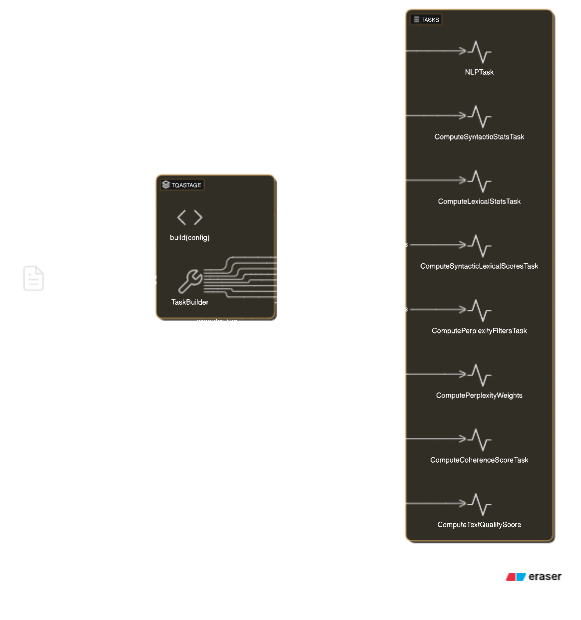

With that, the **Text Quality Analysis Pipeline** is fully specified. Next, we'll introduce the `Dataset` object.

### Dataset
Datasets inherit from the Asset class, which encapsulates core attributes such as the `asset_id`, the `phase` and `stage` in which the asset was created, its `name`, `content`, and date time it was `created`. 

In [12]:
# %load -r 20-119 discover/assets/base.py

from dataclasses import dataclass, fields
from datetime import datetime
from typing import Any, Optional

from discover.assets.idgen import AssetIDGen
from discover.core.data_class import DataClass
from discover.core.flow import PhaseDef, StageDef
from discover.infra.utils.date_time.format import ThirdDateFormatter

# ------------------------------------------------------------------------------------------------ #
dt4mtr = ThirdDateFormatter()


# ------------------------------------------------------------------------------------------------ #
@dataclass
class Asset(DataClass):
    """
    A base class representing an asset in a data pipeline, such as models, datasets, or other entities.

    This class encapsulates common attributes and behaviors associated with assets,
    including tracking their phase, stage, name, content, and creation time.
    It also provides methods for serialization and deserialization, along with
    properties for generating unique IDs and descriptions.

    Attributes:
        asset_id (str): Uniquely identifies an asset.
        phase (PhaseDef): The phase to which the asset belongs.
        stage (StageDef): The stage within the phase.
        name (str): The name of the asset.
        content (Any): The actual content or object the asset represents.
        created (Optional[datetime]): The timestamp when the asset was created.
            If not provided, it is set to the current datetime during initialization.
    """

    asset_id: str
    phase: PhaseDef
    stage: StageDef
    name: str
    content: Any
    created: Optional[datetime] = None

    def __post_init__(self) -> None:
        """
        Initializes the `created` attribute with the current datetime if it was not provided.

        This ensures that the asset's creation time is recorded upon instantiation,
        providing a timestamp for when the asset was initialized.
        """
        self.created = self.created or datetime.now()
        self.asset_id = AssetIDGen.get_asset_id(
            asset_type=self.__class__.__name__.lower(),
            phase=self.phase,
            stage=self.stage,
            name=self.name,
        )

    def __getstate__(self):
        """
        Prepares the object's state for serialization.

        This method converts the object's attributes into a dictionary
        that can be serialized, ensuring compatibility with serialization
        libraries and allowing the asset's state to be stored or transmitted.

        Returns:
            dict: A dictionary representation of the object's state.
        """
        return {field.name: getattr(self, field.name) for field in fields(self)}

    def __setstate__(self, state):
        """
        Restores the object's state from a serialized format.

        This method takes a dictionary representation of the object's state,
        applying it to restore the object's attributes, effectively reconstructing
        the asset after it has been deserialized.

        Args:
            state (dict): The state dictionary used to restore the object.
        """
        for key, value in state.items():
            setattr(self, key, value)

    @property
    def description(self) -> str:
        """
        Provides a detailed description of the asset.

        The description includes information such as the phase, stage, class name,
        and the creation timestamp formatted in HTTP date format. It offers a
        human-readable summary of the asset's key details.

        Returns:
            str: A detailed description of the asset including its phase, stage,
                 class name, and creation time.
        """
        return f"{self.phase.description} - {self.stage.description} {self.__class__.__name__} created on {dt4mtr.to_HTTP_format(self.created)}."

The `Dataset` subclass contains additional attributes, relevant to datasets, such as size, shape and location of the dataset in storage. The `nlp`, and `distributed` attributes determine whether the underlying data are to be materialized as pandas or Spark DataFrames.

In [13]:
# %load -r 20-119 discover/assets/dataset.py

from dataclasses import dataclass
from typing import Any, Optional

import pandas as pd

from discover.assets.base import Asset


# ------------------------------------------------------------------------------------------------ #
@dataclass
class Dataset(Asset):
    """
    Represents a dataset, encapsulating content along with metadata like
    the number of rows, columns, and size.

    Inherits from:
        Asset: Base class that provides phase, stage, content, and storage
        configuration information.

    Attributes:
        nlp (bool): Whether the dataset is part of an NLP pipeline
        distributed (bool): Whether the dataset contents are persisted in a distributed dataframe structure.
        storage_location (Any): Object specifying the storage location for the dataset content payload.
        nrows (int): The number of rows in the dataset. Defaults to 0.
        ncols (int): The number of columns in the dataset. Defaults to 0.
        size (float): The size of the dataset in bytes. Defaults to 0.

    Methods:
        __post_init__() -> None:
            Initializes the `nrows`, `ncols`, and `size` attributes based on
            the type of content provided. If the content is a Spark DataFrame,
            it calculates the number of rows and columns using Spark methods.
            Otherwise, it uses pandas methods for DataFrames.

        __eq__(other: object) -> bool:
            Checks for equality between two `Dataset` instances. Two datasets
            are considered equal if they have the same number of rows, columns,
            and size.
    """

    nlp: bool = False
    distributed: bool = False
    storage_location: Optional[Any] = None
    nrows: int = 0
    ncols: int = 0
    size: float = 0

    def __post_init__(self) -> None:
        """
        Initializes the dataset's `nrows`, `ncols`, and `size` attributes.

        If the content is a Spark DataFrame, it computes the number of rows
        using `count()` and the number of columns from the DataFrame's
        `columns` attribute. The size is calculated by mapping each row to its
        string representation and summing their lengths.

        If the content is a pandas DataFrame, it computes the number of rows
        using `shape[0]`, the number of columns using `shape[1]`, and the size
        using the `memory_usage(deep=True).sum()` method.

        Raises:
            AttributeError: If the `content` does not have the expected attributes
            for row count, column count, or size calculation.
        """
        super().__post_init__()
        if isinstance(self.content, (pd.DataFrame, pd.core.frame.DataFrame)):
            self.nrows = self.content.shape[0]
            self.ncols = self.content.shape[1]
            self.size = self.content.memory_usage(deep=True).sum()
        else:
            self.nrows = self.content.count()
            self.ncols = len(self.content.columns)
            self.size = self.content.count()

    def __eq__(self, other: object) -> bool:
        """
        Checks for equality between two `Dataset` instances.

        Two datasets are considered equal if they have the same number of rows,
        columns, and size. This method overrides the equality operator to facilitate
        direct comparison between `Dataset` objects.

        Args:
            other (object): The object to compare against.

        Returns:
            bool: True if the datasets have the same number of rows, columns, and size;
                  otherwise, False.
        """
        if not isinstance(other, Dataset):
            return NotImplemented
        return (
            self.nrows == other.nrows
            and self.ncols == other.ncols
            and self.size == other.size
        )

### Dataset Repository
The **DatasetRepo** class is responsible for Dataset persistence, ensuring they are stored, retrieved, and persisted efficiently and reliably. It integrates with both centralized (Pandas-based) and distributed (PySpark-based) storage systems, and its core methods include:

   - `add()`: Adds a new dataset, writing its content to the appropriate storage and saving its metadata. It includes rollback mechanisms to maintain data consistency if an error occurs.
   - `get()`: Retrieves a dataset by ID, including its content and metadata, with error handling for cases where the dataset cannot be found or read.
   - `list_all()`, `list_by_phase()`, `list_by_stage()`: Methods to list datasets and filter them based on metadata attributes.
   - `remove()`: Removes a dataset and its associated file(s), with options to suppress errors and perform cleanup.
   - `exists()`: Checks for the existence of a dataset by its ID.

To facilitate efficient IO of large datasets, the underlying data are stored in Parquet files, partitioned by review category for read/write efficiency.

In [14]:
# %load -r 19-527 discover/infra/persistence/repo/dataset.py
import logging
from datetime import datetime
from typing import Callable, Optional, Union

import pandas as pd
import pyspark

from discover.assets.dataset import Dataset
from discover.assets.repo import Repo
from discover.core.flow import PhaseDef
from discover.infra.persistence.dal.dao.dataset import DatasetDAO
from discover.infra.persistence.dal.dao.exception import ObjectNotFoundError
from discover.infra.persistence.dal.fao.centralized import (
    CentralizedFileSystemFAO as FAOCFS,
)
from discover.infra.persistence.dal.fao.distributed import (
    DistributedFileSystemFAO as FAODFS,
)
from discover.infra.persistence.dal.fao.location import FileLocationService
from discover.infra.persistence.repo.exception import (
    DatasetCreationError,
    DatasetExistsError,
    DatasetIntegrityError,
    DatasetIOError,
    DatasetNotFoundError,
    DatasetRemovalError,
)


# ------------------------------------------------------------------------------------------------ #
class DatasetRepo(Repo):
    """
    Repository class for managing dataset storage and retrieval operations.

    This class provides methods to add, retrieve, list, and remove datasets, as well as
    read and write datasets to centralized (Pandas) or distributed (PySpark) file systems.
    It leverages DAOs (Data Access Objects) for interacting with underlying storage mechanisms.

    Args:
        dataset_dao (DatasetDAO): Data Access Object for dataset metadata.
        fao_cfs (FAOCFS): Data Access Object for centralized file storage (e.g., local filesystem).
        fao_dfs (FAODFS): Data Access Object for distributed file storage (e.g., HDFS).
        location_service (LocationService): Service that centralizes the assignment of filepaths.
        partitioned (bool): Whether dataset files are to be partitioned parquet files. Default is True


    Methods:
        add(dataset: Dataset) -> None:
            Adds a new dataset to the storage system.

        get(id: int) -> Optional[Dataset]:
            Retrieves a dataset by its ID.

        list_all() -> pd.DataFrame:
            Returns a DataFrame containing all datasets' metadata.

        list_by_phase(phase: PhaseDef) -> pd.DataFrame:
            Lists datasets filtered by the specified phase.

        list_by_stage(stage: StageDef) -> pd.DataFrame:
            Lists datasets filtered by the specified stage.

        remove(id: int) -> None:
            Removes a dataset and its associated content by its ID.

        exists(id: int) -> bool:
            Checks if a dataset exists by its ID.

    Private Methods:
        _read_file(dataset: Dataset) -> Union[pd.DataFrame, pyspark.sql.DataFrame]:
            Reads a dataset's content

        _read_centralized_file(dataset: Dataset) -> pd.DataFrame:
            Reads a dataset's content from a centralized file system (e.g., local filesystem).

        _read_distributed_file(dataset: Dataset) -> pyspark.sql.DataFrame:
            Reads a dataset's content from a distributed file system (e.g., HDFS).

        _write_file(dataset: Dataset) -> None:
            Writes a dataset's content.

        _write_centralized_file(dataset: Dataset) -> None:
            Writes a dataset's content to a centralized file system.

        _write_distributed_file(dataset: Dataset) -> None:
            Writes a dataset's content to a distributed file system.
    """

    def __init__(
        self,
        dataset_dao: DatasetDAO,
        fao_cfs: FAOCFS,
        fao_dfs: FAODFS,
        location_service: FileLocationService,
        partitioned: bool = True,
    ) -> None:

        self._dataset_dao = dataset_dao
        self._fao_cfs = fao_cfs
        self._fao_dfs = fao_dfs
        self._location_service = location_service
        self._partitioned = partitioned
        self._logger = logging.getLogger(f"{__name__}.{self.__class__.__name__}")

    # -------------------------------------------------------------------------------------------- #
    #                             DATASET CREATION METHODS                                         #
    # -------------------------------------------------------------------------------------------- #
    def add(self, dataset: Dataset) -> Optional[Dataset]:
        """
        Adds a new dataset to the repository. Raises an error if the dataset ID already exists.

        Args:
            dataset (Dataset): The dataset object to be added.

        Returns:
            dataset (Dataset): The dataset object with storage location added.
        Raises:
            FileExistsError: If a dataset with the given ID already exists.
        """
        # Ensure dataset doesn't already exist
        self._validate_add(dataset=dataset)

        # Set the storage location on the dataset object
        dataset.storage_location = self._location_service.get_filepath(
            asset_type=dataset.__class__.__name__.lower(),
            phase=dataset.phase,
            stage=dataset.stage,
            name=dataset.name,
            partition=self._partitioned,
        )

        # Save dataset contents to file.
        try:
            self._write_file(dataset=dataset)
        except Exception as e:
            msg = f"Exception occurred adding dataset {dataset.asset_id} to the repository."
            self._logger.exception(msg)
            raise DatasetIOError(msg, e) from e

        # Save dataset object (metadata and config) to object storage
        try:
            self._dataset_dao.create(dataset=dataset)
        except Exception as e:
            msg = f"Exception occurred while saving dataset {dataset.asset_id} to object storage. Rolling back file persistence."

            # Rollback the file write to maintain consistency.
            try:
                self._remove_dataset_file_by_filepath(filepath=dataset.storage_location)
            except Exception as e:
                fileio_msg = f"Exception occurred while rolling back dataset {dataset.asset_id} persistence."
                self._logger.exception(fileio_msg)
                raise DatasetIOError(fileio_msg, e) from e

            # Raise the original exception
            raise DatasetCreationError(msg, e) from e

    # -------------------------------------------------------------------------------------------- #
    #                             DATASET RETRIEVAL METHODS                                        #
    # -------------------------------------------------------------------------------------------- #
    def get(
        self,
        asset_id: str,
        distributed: Optional[bool] = None,
        nlp: bool = False,
    ) -> Optional[Dataset]:
        """
        Retrieves a dataset by its ID.

        Args:
            asset_id (str): The id of the dataset to retrieve.
            distributed (bool): If True, a distributed (Spark) DataFrame is returned.
                If None, distributed value is obtained from dataset metadata
            nlp (bool): If True, a Spark session for NLP will be used.

        Returns:
            Optional[Dataset]: The dataset object if found; otherwise, None.

        Raises:
            FileNotFoundError: If an error occurs while reading the dataset.
        """
        # Step 1: Obtain the dataset object containing metadata and config.
        try:
            dataset = self._dataset_dao.read(asset_id=asset_id)
        except ObjectNotFoundError:
            msg = f"Dataset {asset_id} does not exist."
            self._logger.exception(msg)
            raise DatasetNotFoundError(msg)
        except Exception as e:
            msg = f"Exception occurred while reading the dataset {asset_id} object."
            self._logger.exception(msg)
            raise DatasetIOError(msg, e) from e

        # Step 2: Get the dataset contents from file, add to dataset object and return
        try:
            dataset.content = self._read_file(
                dataset=dataset, distributed=distributed, nlp=nlp
            )
            return dataset
        except FileNotFoundError as e:
            msg = f"Exception occurred while reading dataset {dataset.asset_id}. File containing dataset contents was not found at {dataset.storage_location}.\n{e}"
            self._logger.exception(msg)
            raise DatasetIntegrityError(msg)
        except Exception as e:
            if "[PATH_NOT_FOUND]" in str(e):
                msg = f"Exception occurred while reading dataset {dataset.asset_id}. File containing dataset contents was not found at {dataset.storage_location}.\n{e}"
                self._logger.exception(msg)
                raise DatasetIntegrityError(msg)
            else:
                msg = f"Exception occurred while reading dataset {dataset.asset_id} contents from file."
                self._logger.exception(msg)
                raise DatasetIOError(msg, e) from e

    # -------------------------------------------------------------------------------------------- #
    def select(self, asset_id: str, condition: Callable) -> pd.DataFrame:
        """
        Selects and returns rows from the asset data that meet a specified condition.

        Parameters
        ----------
        asset_id : str
            The unique identifier for the asset from which to retrieve data.

        condition : Callable
            A lambda function or callable expression that filters the DataFrame rows.
            This function should accept a DataFrame and return a boolean Series to filter rows
            (e.g., `lambda x: x['date'] > some_date`).

        Returns
        -------
        pd.DataFrame
            A DataFrame containing only the rows that satisfy the specified condition.

        Example
        -------
        >>> select("asset_123", lambda x: x['date'] > '2023-01-01')
        """
        df = self.get(asset_id=asset_id)
        return df[condition]

    # -------------------------------------------------------------------------------------------- #
    def get_dataset_metadata(self, asset_id: str) -> Optional[Dataset]:
        """
        Retrieves a dataset with metadata only.

        Args:
            asset_id (str): The id of the dataset to retrieve.

        Returns:
            Optional[Dataset]: The dataset object containing just metadata if found; otherwise, None.

        Raises:
            FileNotFoundError: If an error occurs while reading the dataset.
        """
        # Step 1: Obtain the dataset object containing metadata and config.
        try:
            return self._dataset_dao.read(asset_id=asset_id)
        except ObjectNotFoundError:
            msg = f"Dataset {asset_id} does not exist."
            self._logger.exception(msg)
            raise DatasetNotFoundError(msg)
        except Exception as e:
            msg = f"Exception occurred while reading the dataset {asset_id} object."
            self._logger.exception(msg)
            raise DatasetIOError(msg, e) from e

    # -------------------------------------------------------------------------------------------- #
    def update_dataset_metadata(self, dataset: Dataset) -> None:
        """
        Updates the metadata for a dataset.

        Args:
            asset_id (str): The id of the dataset to retrieve.

        Returns:
            Optional[Dataset]: The dataset object containing just metadata if found; otherwise, None.

        Raises:
            FileNotFoundError: If an error occurs while reading the dataset.
        """
        # Step 1: Obtain the dataset object containing metadata and config.
        try:
            return self._dataset_dao.update(dataset=dataset)
        except Exception as e:
            msg = f"Metadata for dataset {dataset.asset_id} could not be updated.\n{e}"
            self._logger.exception(msg)
            raise DatasetIOError(msg, e) from e

    # -------------------------------------------------------------------------------------------- #
    def is_consumed(self, asset_id: str) -> bool:
        """Returns the True if the dataset has been marked as consumed, False otherwise.

        Args:
            asset_id (str): The dataset asset identifier.

        Returns:
            bool: True if the Dataset has been created, but not yet consumed.
        """
        dataset = self.get_dataset_metadata(asset_id=asset_id)
        return dataset.consumed

    # -------------------------------------------------------------------------------------------- #
    def consumed(self, asset_id: str, consumer: str = None) -> None:
        """Marks the dataset as having been consumed.

        Args:
            asset_id (str): The identifier for the dataset asset.
            consumer (str): The name of the Task that consumed the dataset.
        """
        dataset = self.get_dataset_metadata(asset_id=asset_id)
        dataset.consumed = True
        dataset.dt_consumed = datetime.now()
        dataset.consumed_by = consumer
        self.update_dataset_metadata(dataset=dataset)

    # -------------------------------------------------------------------------------------------- #
    def _read_file(
        self, dataset: Dataset, distributed: Optional[bool] = None, nlp: bool = False
    ) -> Union[pd.DataFrame, pyspark.sql.DataFrame]:
        """
        Reads a dataset's content based on its storage configuration.

        Args:
            dataset (Dataset): The dataset to read.
            distributed (Optional[bool]): Indicates whether the dataset should be read
                as a distributed dataset (Spark) or centralized (Pandas)
            nlp (bool): Whether to obtain data using a NLP spark session.

        Returns:
            Union[pd.DataFrame, pyspark.sql.DataFrame]: The dataset's content.
        """
        if distributed is None:
            distributed = dataset.distributed

        if distributed:
            return self._read_distributed_file(dataset=dataset, nlp=nlp)
        else:
            return self._read_centralized_file(dataset=dataset)

    # -------------------------------------------------------------------------------------------- #
    def _read_centralized_file(self, dataset: Dataset) -> pd.DataFrame:
        """
        Reads a dataset's content from a centralized file system.

        Args:
            dataset (Dataset): The dataset to read.

        Returns:
            pd.DataFrame: The content of the dataset.
        """
        return self._fao_cfs.read(filepath=dataset.storage_location)

    # -------------------------------------------------------------------------------------------- #
    def _read_distributed_file(
        self, dataset: Dataset, nlp: bool = False
    ) -> pyspark.sql.DataFrame:
        """
        Reads a dataset's content from a distributed file system.

        Args:
            dataset (Dataset): The dataset to read.

        Returns:
            pyspark.sql.DataFrame: The content of the dataset.
        """
        nlp = dataset.nlp or nlp
        return self._fao_dfs.read(filepath=dataset.storage_location, nlp=nlp)

    # -------------------------------------------------------------------------------------------- #
    #                               DATASET LIST METHODS                                           #
    # -------------------------------------------------------------------------------------------- #
    def list_all(self) -> pd.DataFrame:
        """
        Lists all datasets' metadata.

        Returns:
            pd.DataFrame: A DataFrame containing metadata for all datasets.
        """
        return self._dataset_dao.read_all()

    # -------------------------------------------------------------------------------------------- #
    def list_by_phase(self, phase: PhaseDef) -> pd.DataFrame:
        """
        Lists datasets filtered by the specified phase.

        Args:
            phase (PhaseDef): The phase to filter datasets by.

        Returns:
            pd.DataFrame: A DataFrame containing metadata for the filtered datasets.
        """
        return self._dataset_dao.read_by_phase(phase=phase)

    # -------------------------------------------------------------------------------------------- #
    #                             DATASET REMOVAL METHODS                                          #
    # -------------------------------------------------------------------------------------------- #
    def remove(self, asset_id: str, ignore_errors: bool = False) -> None:
        """
        Removes a dataset and its associated file(s) from the repository.

        This method attempts to remove both the dataset object and its related file(s).
        If the dataset object does not exist, and `ignore_errors` is set to True, the method will still
        search for and remove any related dataset files. If `ignore_errors` is False, it will raise an exception
        if the dataset object or file cannot be found or deleted.

        Args:
            asset_id (str): The id of the dataset to be removed.
            ignore_errors (bool): If True, suppresses any exceptions during the removal process
                and logs warnings instead of raising errors. Default is False.

        Raises:
            DatasetRemovalError: If any error occurs while removing the dataset object or file, and `ignore_errors` is False.
        """
        # Obtain the dataset object and storage information from the repository
        if self._dataset_dao.exists(asset_id=asset_id):
            dataset = self._dataset_dao.read(asset_id=asset_id)
            # Delete the dataset file from the repository
            self._remove_dataset_file_by_filepath(filepath=dataset.storage_location)
            # Delete the dataset object.
            self._dataset_dao.delete(asset_id=asset_id)
            msg = f"Removed dataset {asset_id} from the repository."
            self._logger.info(msg)
        # If ignoring errors, issue a warning and search for file remnants by name.
        elif ignore_errors:
            msg = f"Warning: Dataset {asset_id} does not exist."
            self._logger.warning(msg)
        # Otherwise throw a DatasetRemovalError
        else:
            msg = f"Exception: Dataset {asset_id} does not exist"
            self._logger.exception(msg)
            raise DatasetRemovalError(msg)

    # -------------------------------------------------------------------------------------------- #
    def _remove_dataset_file_by_filepath(self, filepath: str) -> None:
        """
        Removes the dataset file located at the specified filepath if it exists.

        Args:
            filepath (str): The path of the dataset file to be removed.
        """
        if self._fao_cfs.exists(filepath=filepath):
            self._fao_cfs.delete(filepath)
            msg = f"Removed dataset file at {filepath} from repository."
            self._logger.info(msg)

    # -------------------------------------------------------------------------------------------- #
    #                             DATASET EXISTENCE METHOD                                         #
    # -------------------------------------------------------------------------------------------- #
    def exists(self, asset_id: str) -> bool:
        """
        Checks if a dataset exists by its ID.

        Args:
            asset_id (str): The id to check for existence.

        Returns:
            bool: True if the dataset exists, False otherwise.
        """
        return self._dataset_dao.exists(asset_id=asset_id)

    # -------------------------------------------------------------------------------------------- #
    def _validate_add(self, dataset: Dataset) -> None:
        """Ensures dataset object and file doesn't already exist"""
        if self.exists(asset_id=dataset.asset_id):
            msg = f"Unable to add dataset {dataset.asset_id} as it already exists."
            self._logger.error(msg)
            raise DatasetExistsError(msg)

    # -------------------------------------------------------------------------------------------- #
    #                             DATASET WRITE METHODS                                            #
    # -------------------------------------------------------------------------------------------- #
    def _write_file(self, dataset: Dataset) -> None:
        """
        Writes a dataset's content.

        Args:
            dataset (Dataset): The dataset to write.
        """
        if dataset.distributed:
            self._write_distributed_file(dataset=dataset)
        else:
            self._write_centralized_file(dataset=dataset)

    # -------------------------------------------------------------------------------------------- #
    def _write_centralized_file(self, dataset: Dataset) -> None:
        """
        Writes a dataset's content to a centralized file system.

        Args:
            dataset (Dataset): The dataset to write.
        """
        self._fao_cfs._write(
            filepath=dataset.storage_location,
            data=dataset.content,
        )

    # -------------------------------------------------------------------------------------------- #
    def _write_distributed_file(self, dataset: Dataset) -> None:
        """
        Writes a dataset's content to a distributed file system.

        Args:
            dataset (Dataset): The dataset to write.
        """
        self._fao_dfs._write(
            filepath=dataset.storage_location,
            data=dataset.content,
        )

### Task
The **Task** class serves as an abstract base class for the tasks such as the **Text Quality Analysis Pipeline** tasks defined earlier. It ensures that every task has a `name` property (accessed by the task_logger decorator) and a `run` method that executes the Task's core logic. 

In [15]:
# %load -r 20-84 discover/flow/base/task.py

import importlib
import logging
from abc import ABC, abstractmethod
from typing import Any


# ------------------------------------------------------------------------------------------------ #
#                                           TASK                                                   #
# ------------------------------------------------------------------------------------------------ #
class Task(ABC):
    """
    An abstract base class for defining tasks in a pipeline.
    All tasks must implement the `run` method and provide a
    `name` property based on the class name.

    Methods:
    --------
    name -> str
        Returns the name of the task, which is the class name of the task instance.

    run(*args, data: Any, **kwargs) -> Any
        Abstract method that must be implemented by any subclass. It represents
        the main logic of the task. Subclasses should specify the expected inputs
        and outputs.
    """

    def __init__(self):
        self._logger = logging.getLogger(f"{__name__}.{self.__class__.__name__}")

    @property
    def name(self) -> str:
        """
        Returns the name of the task, which is the class name of the task instance.

        Returns:
        --------
        str
            The name of the task.
        """
        return self.__class__.__name__

    @abstractmethod
    def run(self, *args, data: Any, **kwargs) -> Any:
        """
        The core logic of the task. Must be implemented by any subclass.

        Parameters:
        -----------
        *args : tuple
            Positional arguments that the task may require.
        data : Any
            The input data for the task. The specific type of data will depend
            on the implementation of the subclass.
        **kwargs : dict
            Additional keyword arguments that the task may require.

        Returns:
        --------
        Any
            The output of the task, as defined by the subclass implementation.
        """
        pass

### Task Builder 
The **TaskBuilder** class is a utility for dynamically constructing task instances from configuration data. It uses a static method, `build`, to read the provided configuration dictionary and create an instance of the specified task class based on the `task_config` dictionary which includes keys such as `module_name` (where the task class is defined), `class_name` (the name of the task class), and `params` (arguments to pass to the class constructor).

In [16]:
# %load -r 129-200 discover/flow/base/task.py
class TaskBuilder:
    """
    A builder class for constructing task instances from configuration data.

    The `TaskBuilder` class provides a static method, `build`, which reads task configuration
    data and dynamically creates an instance of the specified task class using the provided
    parameters. This allows for flexible and dynamic task instantiation based on configuration.

    Methods
    -------
    build(task_config: dict) -> object
        Constructs and returns an instance of a task class using the specified configuration.

    Examples
    --------
    >>> task_config = {
    ...     'module_name': 'mypackage.mymodule',
    ...     'class_name': 'NormalizationTask',
    ...     'params': {'param1': value1, 'param2': value2}
    ... }
    >>> task_instance = TaskBuilder.build(task_config)
    """

    @staticmethod
    def build(task_config):
        """
        Builds and returns an instance of a task class based on the provided configuration.

        Parameters
        ----------
        task_config : dict
            A dictionary containing task configuration with the following keys:
                - 'phase' (str): The phase associated with the task (e.g., 'preprocessing').
                - 'stage' (str): The stage within the phase (e.g., 'normalization').
                - 'module_name' (str): The name of the module containing the task class.
                - 'class_name' (str): The name of the task class to instantiate.
                - 'params' (dict): Additional parameters to pass to the task's constructor.

        Returns
        -------
        object
            An instance of the specified task class initialized with the provided parameters.

        Raises
        ------
        ModuleNotFoundError
            If the specified module cannot be found.
        AttributeError
            If the specified class does not exist in the module.
        TypeError
            If the class constructor does not accept the provided parameters.

        Examples
        --------
        >>> task_config = {
        ...     'module_name': 'mypackage.mymodule',
        ...     'class_name': 'NormalizationTask',
        ...     'params': {'param1': value1, 'param2': value2}
        ... }
        >>> task_instance = TaskBuilder.build(task_config)
        """
        module = task_config["module"]
        class_name = task_config["class_name"]
        params = task_config["params"]
        return instantiate_class(
            module=module,
            class_name=class_name,
            params=params,
        )

The **TaskBuilder** delegates class instantiation to the `instantiate_class` function, which dynamically imports a module and creates an instance of a specified class using the provided parameters.

In [17]:
# %load -r 86-125 discover/flow/base/task.py
def instantiate_class(module: str, class_name: str, params: dict):
    """
    Dynamically imports a module and instantiates a class with the given parameters.

    Parameters
    ----------
    module : str
        The name of the module from which to import the class (e.g., 'mypackage.mymodule').
    class_name : str
        The name of the class to instantiate from the module.
    params : dict
        A dictionary of additional parameters to pass to the class constructor.

    Returns
    -------
    object
        An instance of the specified class with the provided parameters.

    Raises
    ------
    ModuleNotFoundError
        If the specified module cannot be found.
    AttributeError
        If the specified class does not exist in the module.
    TypeError
        If the class constructor does not accept the provided parameters.

    Examples
    --------
    >>> obj = instantiate_class(
    ...     module='mypackage.mymodule',
    ...     class_name='Normalizer',
    ...     params={'param1': value1, 'param2': value2}
    ... )
    """
    module = importlib.import_module(module)
    cls = getattr(module, class_name)
    return cls(**params)

## Stage
Task orchestration occurs in Stage classes, which define a logic unit of work comprised of a series of Task objects. The **Stage** class defines the interface for pipeline Stage subclasses and through its `build` class method, controls the construction and instantiation of Stage objects, leveraging the TaskBuilder to instantiate the Task instances.

In [18]:
# %load -r 19-159 discover/flow/base/stage.py
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import List, Type

from discover.core.flow import PhaseDef, StageDef
from discover.core.namespace import NestedNamespace
from discover.flow.base.task import Task, TaskBuilder


# ------------------------------------------------------------------------------------------------ #
#                                        STAGE                                                     #
# ------------------------------------------------------------------------------------------------ #
class Stage(ABC):
    """Abstract base class for pipeline stages.

    This class provides the foundation for creating and executing stages in a data pipeline.
    A stage typically involves loading source data, applying a series of tasks to the data,
    and saving the processed data to a destination. The stage is configurable with source
    and destination settings and a list of tasks to be executed.

    Attributes:
        _source_config (NestedNamespace): Configuration dictionary for the source dataset.
        _destination_config (NestedNamespace): Configuration dictionary for the destination dataset.
        _task_builder (Type[TaskBuilder]): The builder class responsible for constructing tasks.
        _tasks (List[Task]): A list of tasks to be executed in this stage.
        _force (bool): Whether to force execution even if the destination dataset exists.

    Methods:
        phase (PhaseDef): The phase of the pipeline.
        stage (StageDef): The specific stage of the pipeline.
        run() -> str: Executes the pipeline stage.
        build(stage_config: dict, force: bool = False) -> Stage: Creates and returns a new stage instance.
    """

    def __init__(
        self,
        source_config: dict,
        destination_config: dict,
        tasks: List[Task],
        task_builder: Type[TaskBuilder] = TaskBuilder,
        force: bool = False,
    ) -> None:
        """Initializes the Stage pipeline with the provided configuration and tasks.

        Args:
            source_config (dict): Configuration for the source dataset.
            destination_config (dict): Configuration for the destination dataset.
            tasks (List[Task]): List of tasks to be applied in the pipeline stage.
            task_builder (Type[TaskBuilder], optional): The task builder class to use for constructing tasks.
                Defaults to `TaskBuilder`.
            force (bool, optional): Whether to force execution even if the destination dataset exists.
                Defaults to `False`.

        Raises:
            ValueError: If source_config or destination_config are invalid or incomplete.
            RuntimeError: For other initialization errors.
        """
        try:
            self._source_config = NestedNamespace(source_config)
            self._destination_config = NestedNamespace(destination_config)
            self._task_builder = task_builder
            self._tasks = tasks
            self._force = force
        except KeyError as e:
            raise ValueError(f"Missing required configuration key: {str(e)}") from e
        except Exception as e:
            raise RuntimeError(
                f"Failed to initialize the Stage with the provided configuration: {str(e)}"
            ) from e

    @property
    @abstractmethod
    def phase(self) -> PhaseDef:
        """Returns the phase of the pipeline.

        This property is meant to categorize the stage within the larger pipeline process.
        """
        pass

    @property
    @abstractmethod
    def stage(self) -> StageDef:
        """Returns the specific stage within the pipeline.

        This property helps identify which stage of the pipeline is being executed.
        """
        pass

    @abstractmethod
    def run(self) -> str:
        """Executes the stage and returns the resulting asset ID.

        This method orchestrates the execution of the tasks defined in the stage,
        processes the source data, and saves the result to the destination.

        Returns:
            str: The asset ID of the generated dataset.

        Raises:
            RuntimeError: If an error occurs during the execution of the stage.
        """
        pass

    @classmethod
    def build(cls, stage_config: dict, force: bool = False) -> Stage:
        """Creates and returns a new stage instance from the provided configuration.

        Args:
            stage_config (dict): The configuration dictionary containing source, destination, and tasks details.
            force (bool, optional): Whether to force execution even if the destination dataset exists. Defaults to `False`.

        Returns:
            Stage: A new instance of the Stage class, configured with the provided settings.

        Raises:
            KeyError: If the required keys are missing from the stage_config.
            ValueError: If tasks cannot be built from the configuration.
            RuntimeError: If there is an error creating the stage.
        """
        try:
            tasks = [
                cls._task_builder.build(task_config)
                for task_config in stage_config["tasks"]
            ]
            return cls(
                source_config=stage_config["source_config"],
                destination_config=stage_config["destination_config"],
                tasks=tasks,
                force=force,
            )
        except KeyError as e:
            raise ValueError(
                f"Missing required configuration key in stage_config: {str(e)}"
            ) from e
        except Exception as e:
            raise RuntimeError(
                f"Failed to build stage from configuration: {str(e)}"
            ) from e

### Data Preparation Stage
Finally, we have the **DataPrepStage** class, the orchestrator of data preparation activities from loading source data to executing a series of tasks and saving the processed data. The `run` method is where the action occurs.  It loads the source data, applies each task in order, creates a destination dataset, and saves it. Supporting methods include: 
  - **_load_source_data()**: Loads the source dataset from the repository, ensuring it’s properly configured and renamed if necessary.
  - **_create_destination_dataset()**: Constructs a `Dataset` object with the processed data and configuration details.
  - **_save_destination_dataset()**: Saves the processed dataset to the repository, raising errors if the operation fails.
  - **_endpoint_exists()**: Checks if the dataset endpoint already exists in the repository.
  - **_remove_destination_dataset()**: Removes an existing destination dataset from the repository if necessary.

The **DataPrepStage** subclasses implement any stage specific variations, such as the `IngestStage` which takes its input from a raw data file, rather than the repository. Yet, the core logic implemented in the **DataPrepStage** defines orchestration policy from ingestion, through data cleaning and feature engineering.

In [19]:
# %load -r 22-303 discover/flow/data_processing/data_prep/base/stage.py
from typing import List, Type, Union

import pandas as pd
from pyspark.sql import DataFrame

from discover.assets.dataset import Dataset
from discover.assets.idgen import AssetIDGen
from discover.core.namespace import NestedNamespace
from discover.flow.base.task import Task
from discover.flow.data_processing.base.stage import DataProcessingStage
from discover.infra.service.logging.stage import stage_logger


# ------------------------------------------------------------------------------------------------ #
#                                    DATA PREP STAGE                                               #
# ------------------------------------------------------------------------------------------------ #
class DataPrepStage(DataProcessingStage):
    """
    A stage class for preparing datasets, handling loading, processing, and saving of data.

    This class orchestrates the execution of data preparation tasks, including loading source datasets,
    applying a series of tasks, and saving the processed data to a destination repository.

    Parameters
    ----------
    source_config : dict
        Configuration for the source dataset, including details like phase, stage, and name.
    destination_config : dict
        Configuration for the destination dataset, including details like phase, stage, and name.
    tasks : List[Task]
        A list of tasks to execute as part of the data preparation stage.
    force : bool, optional
        Whether to force execution if the destination dataset endpoint already exists (default is False).
    repo : DatasetRepo, optional
        A repository for dataset persistence, injected via dependency injection (default is `DiscoverContainer.repo.dataset_repo`).
    **kwargs : dict
        Additional keyword arguments for stage configuration.

    Attributes
    ----------
    _repo : DatasetRepo
        The repository instance used for dataset persistence.
    _source_asset_id : str
        The generated asset ID for the source dataset based on the configuration.
    _destination_asset_id : str
        The generated asset ID for the destination dataset based on the configuration.
    _logger : logging.Logger
        Logger instance for logging events related to the data preparation stage.

    Methods
    -------
    run() -> str
        Executes the stage by loading the source dataset, applying tasks, and saving the result.
    _create_destination_dataset(data: Union[pd.DataFrame, pyspark.sql.DataFrame]) -> Dataset
        Creates the destination dataset with the processed data and configuration details.
    _load_source_dataset() -> Dataset
        Loads the source dataset from the repository using the source asset ID.
    _save_destination_dataset(dataset: Dataset) -> None
        Saves the processed dataset to the repository using the destination asset ID.
    _endpoint_exists(asset_id: str) -> bool
        Checks if the dataset endpoint already exists in the repository.

    Notes
    -----
    The `DataPrepStage` class leverages dependency injection to retrieve a dataset repository instance.
    It ensures that datasets are properly loaded and saved based on the specified configurations.
    """

    def __init__(
        self,
        source_config: dict,
        destination_config: dict,
        tasks: List[Task],
        asset_idgen: Type[AssetIDGen] = AssetIDGen,
        force: bool = False,
        **kwargs,
    ) -> None:
        """
        Initializes the data preparation stage with source and destination configurations, tasks, and optional parameters.

        Args:
            source_config (dict): Configuration details for the source dataset.
            destination_config (dict): Configuration details for the destination dataset.
            tasks (List[Task]): List of tasks to run during this stage.
            force (bool, optional): If True, forces execution even if the destination dataset exists (default is False).
            repo (DatasetRepo, optional): Repository for dataset persistence, injected via dependency injection.
        """
        super().__init__(
            source_config=source_config,
            destination_config=destination_config,
            tasks=tasks,
            force=force,
        )

    @stage_logger
    def run(self) -> str:
        """
        Executes the data preparation stage by loading the source dataset, applying tasks, and saving the processed result.

        Args:
            None

        Returns:
            str: The asset ID of the destination dataset.

        Raises:
            DatasetNotFoundError: If the source dataset cannot be loaded from the repository.
            DatasetSaveError: If there is an error saving the processed dataset.
        """
        # Obtain the source and destination asset identifiers for repository access
        source_asset_id = self._get_asset_id(config=self._source_config)
        destination_asset_id = self._get_asset_id(config=self._destination_config)
        # Determine whether the endpoint already exists
        endpoint_exists = self._dataset_exists(asset_id=destination_asset_id)

        # Determine execution path
        if self._force:
            if endpoint_exists:
                self._remove_dataset(asset_id=destination_asset_id)
            self._run_task(
                source_asset_id=source_asset_id,
                destination_asset_id=destination_asset_id,
            )
        elif endpoint_exists:  # and not forcing execution
            # Check if the source data has already been consumed
            if not self._is_consumed(asset_id=source_asset_id):
                # Updated endpoint with fresh data.
                self._update_endpoint(
                    source_asset_id=source_asset_id,
                    destination_asset_id=destination_asset_id,
                )  # Stage specific

        else:
            self._run_task(
                source_asset_id=source_asset_id,
                destination_asset_id=destination_asset_id,
            )
        return destination_asset_id

    def _update_endpoint(self, source_asset_id, destination_asset_id):
        """Updates the endpoint dataset with changes in the source dataset.

        Args:
            source_asset_id (str): The asset identifier for the input dataset.
            destination_asset_id (str): The asset identifier for the output dataset.
        """

        # Obtain the source and destination datasets
        source_dataset = self._load_dataset(
            asset_id=source_asset_id, config=self._source_config
        )
        destination_dataset = self._load_dataset(
            asset_id=destination_asset_id, config=self._destination_config
        )
        # Extract the id column and columns created by this process and added to the destination dataset
        # prefixed by the stage that created the column.
        tqd_cols = [
            col
            for col in destination_dataset.content.columns
            if col.startswith(self.stage_prefix) or col == "id"
        ]
        # Update the destination dataset with updated source dataset content
        destination_dataset.content = source_dataset.content.merge(
            destination_dataset.content[tqd_cols], how="left", on="id"
        )
        # Save the destination dataset.
        self._save_dataset(dataset=destination_dataset)
        # Mark the source dataset metadata as consumed.
        source_dataset = self._consumed(dataset=source_dataset)
        # Save the source dataset metadata
        self._save_dataset_metadata(dataset=source_dataset)

    def _run_task(self, source_asset_id: str, destination_asset_id: str) -> None:
        """Performs the core logic of the Stage, executing tasks in sequence"""
        # Obtain the source dataset
        source_dataset = self._load_dataset(
            asset_id=source_asset_id, config=self._source_config
        )
        # Extract the payload
        data = source_dataset.content
        # Iterate through tasks. Default behavior is that task output is input for subsequent task
        for task in self._tasks:
            data = task.run(data=data)

        # Create the destination dataset
        destination_dataset = self._create_dataset(
            asset_id=destination_asset_id, config=self._destination_config, data=data
        )
        self._save_dataset(dataset=destination_dataset)

        # Mark the source dataset as having been consumed.
        source_dataset = self._consumed(dataset=source_dataset)
        # Save the source dataset metadata only. We can do this without integrity errors as
        # the dataset content is immutable.
        self._save_dataset_metadata(dataset=source_dataset)

    def _is_consumed(self, asset_id: str) -> bool:
        """Returns a boolean indicating whether the data for the given asset_id is fresh.

        Args:
            asset_id (str): The asset identifier for the dataset

        Returns:
            bool: True if the dataset is fresh.
        """
        try:
            return self._repo.is_consumed(asset_id=asset_id)
        except Exception as e:
            msg = f"Error checking dataset {asset_id} freshness: {str(e)}"
            self._logger.error(msg)
            raise RuntimeError(msg)

    def _consumed(self, dataset: Dataset) -> Dataset:
        """Marks the dataset as having been consumed"""
        dataset.consumed = True
        dataset.dt_consumed = datetime.now()
        dataset.consumed_by = self.__class__.__name__
        return dataset

    def _load_dataset(
        self, asset_id: str, config: NestedNamespace
    ) -> Union[pd.DataFrame, DataFrame]:
        """
        Loads the a dataset from the repository.

        Args:
            asset_id (str): The identifier for the dataset asset.
            config (NestedNamespace): Dataset configuration Specifies whether the load the
                dataset as a pandas or distributed  (PySpark) DataFrame with or without NLP
                dependencies.

        Returns:
            Union[pd.DataFrame, DataFrame]: Pandas or PySpark DataFrame.

        Raises:
            FileNotFoundError: If the source dataset cannot be found or loaded.
            RuntimeError: If unrecognized error occurs.
        """
        try:
            dataset = self._repo.get(
                asset_id=asset_id,
                distributed=config.distributed,
                nlp=config.nlp,
            )
            # Marks the dataset as no longer fresh acknowledging the dataset has been
            # consumed to avoid unnecessary processing in future executions when data
            # hasn't changed.
            self._repo.consumed(asset_id=asset_id)

            if config.distributed:
                # Rename the pandas index column if it exists. This is annoyance that occurs
                # when a file saved with pandas indexes is read as a PySpark DataFrame
                if "__index_level_0__" in dataset.content.columns:
                    dataset.content = dataset.content.withColumnRenamed(
                        "__index_level_0__", "pandas_index"
                    )
            return dataset
        except FileNotFoundError as e1:
            msg = f"Dataset {asset_id} not found in the repository.\n{e1}"
            self._logger.error(msg)
            raise FileNotFoundError(msg)
        except Exception as e2:
            msg = f"RuntimeError encountered while attempting to load dataset {asset_id}.\n{e2}"
            self._logger.error(msg)
            raise RuntimeError(msg)

    def _save_dataset_metadata(self, dataset: Dataset) -> None:
        """
        Saves a dataset metadata to the repository.

        Args:
            dataset (Dataset): The dataset to be saved.

        Raises:
            RuntimeError: If saving the dataset fails.
        """
        try:
            self._repo.update_dataset_metadata(dataset=dataset)
        except Exception as e:
            raise RuntimeError(f"Failed to save dataset metadata\n{dataset}\n{str(e)}")

## Summary

We began with the following simple, abstract piece of code to configure and execute the **Text Quality Analysis (TQA) Pipeline**.

While concise, this initial implementation lacked transparency, discoverability, and reproducibility. To address these shortcomings, we embarked on a odyssey to dissect and understand the essential components of our pipeline orchestration architecture.

#### Steps Taken
- **Task Definition**: We defined the individual tasks required for the Text Quality Analysis Pipeline, ensuring each task's logic was clear and reproducible.
- **Pipeline Construction**: We assembled the TQA Pipeline using the eight core components of our orchestration framework, including stages, tasks, and data management entities. This provided us with a robust, configuration-driven approach to workflow management.

We have now come full circle, revisiting the original four lines of code that build and execute the pipeline. However, armed with an understanding of the underlying components and how they interact, the abstract code is no longer a black box, but (we hope) an *understandable* abstraction that effectively hides complexity, without introducing cognitive burden or new friction-inducing complexities. 

With that, runall in 3,2,...  


In [20]:
# Obtain the configuration
reader = FlowConfigReader()
stage_config = reader.get_stage_config(phase=PhaseDef.DATAPREP, stage=StageDef.TQA)

# Build and run Data Ingestion Stage
stage = TQAStage.build(stage_config=stage_config, force=FORCE)
asset_id = stage.run()



# ============================================================================== #
#                          Text Quality Analysis Stage                           #
# ============================================================================== #



your 131072x1 screen size is bogus. expect trouble


:: loading settings :: url = jar:file:/home/john/miniconda3/envs/appvocai/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/john/.ivy2/cache
The jars for the packages stored in: /home/john/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6a70032e-bed4-49ad-9247-fa976969d383;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.3.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	f



                                    NLPTask                                     
                                    -------                                     
                          Start Datetime | Mon, 18 Nov 2024 04:18:45
pos_ud_ewt download started this may take some time.
Approximate size to download 2.2 MB
[ | ]pos_ud_ewt download started this may take some time.
Approximate size to download 2.2 MB
[ / ]Download done! Loading the resource.


[ — ]

[OK!]
                       Complete Datetime | Mon, 18 Nov 2024 04:19:06
                                 Runtime | 21.1 seconds


                             ComputeTextQualityTask                             
                             ----------------------                             
                          Start Datetime | Mon, 18 Nov 2024 04:19:06
                       Complete Datetime | Mon, 18 Nov 2024 04:19:07
                                 Runtime | 0.89 seconds




                          Text Quality Analysis Stage                           
                           Stage Started | Mon, 18 Nov 2024 04:18:21
                         Stage Completed | Mon, 18 Nov 2024 04:20:33
                           Stage Runtime | 2.0 minutes and 12.35 seconds


# ============================================================================ #



## Summary and Transition to the Data Quality Analysis (DQA):
With the **Text Quality Analysis (TQA) Pipeline** now complete, we have the linguistic elements that contribute to a holistic assessment of text quality for NLP applications. These enriched text quality measures are determinative inputs for our next stage: the **Data Quality Analysis (DQA)**. 

In the DQA, we’ll dilate our aperture, integrating sentiments, typographical, and linguistic metrics across several dimensions of data quality, allowing us to uncover areas of concern, and devise further data processing interventions. 